# Projeto - Séries Temporais
## Residência em Ciência de Dados - SAMSUNG/UFPE

### Alunos:
- Lucas Couri (lncc2)
- Mariama Oliveira (mcso)

# Bibliotecas

In [1]:
#import statsmodels.api as sm
import statsmodels.tsa.api as tsa
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=Warning)
#import matplotlib as mpl
#import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

#mpl.rcParams['figure.figsize'] = [10, 5]

results = {}

Utilizamos o dataset disponível no Kaggle sobre as temperaturas médias em Delhi (https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data). O dataset já era dividido em train e test, portanto, juntamos os dois datasets para depois separar em train e test da forma desejada.

In [2]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_delhi.csv")

In [3]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)


In [4]:
df.shape

(1575, 1)

In [5]:
df.tail()

meantemp
date                
2017-04-20    34.500
2017-04-21    34.250
2017-04-22    32.900
2017-04-23    32.875
2017-04-24    32.000

Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [6]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

#### Funções de apoio

Algumas funções construídas para exibir e salvar as métricas de cada modelo e plotar os gráficos de ajuste e predição.

In [7]:
def show_metrics(y_test,prediction, results, name):
    print(f'{name} - model Results')
    print('r2' , r2_score(prediction, y_test))
    print('mse' ,mean_squared_error(prediction, y_test))
    print('mae', mean_absolute_error(prediction, y_test))
    print('mape', mean_absolute_percentage_error(prediction, y_test))
    metrics = {'r2':r2_score(prediction, y_test), \
                    'mse': mean_squared_error(prediction, y_test), 
                    'mae': mean_absolute_error(prediction, y_test),
                    'mape': mean_absolute_percentage_error(prediction, y_test)}
    results[name] = metrics
    return metrics
    

def graf_ajuste(pred, train, titulo):
    #Previsão do treino
    fig, ax = plt.subplots()
    ax.plot(pred, label='pred')
    ax.plot(train, label='true')
    plt.title(titulo)
    plt.legend()

def graf_pred(fc, train, test, titulo, SVR=False):
    
    fc_series = pd.Series(fc, index=test.index[1:])

    #if(SVR==True):
    #    fc = fitted
    #    fc_series = pd.Series(fc, index=test.index[1:])
    #else:
        #fitted2 = fitted.apply(test)
        #fc = fitted2.predict(start='2016-03-28', end='2017-04-24')  # 95% conf
        #fc_series = pd.Series(fc, index=test.index)

    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(fc_series, label='Predição')
    plt.title(titulo)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

## Plot

Plotando a série temporal da temperatura média de Delhi

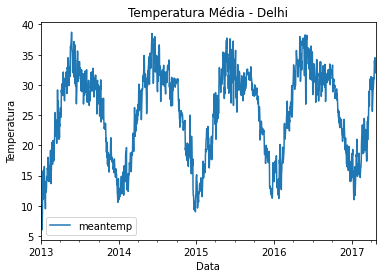

In [8]:
df.plot()
plt.title("Temperatura Média - Delhi")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

## Decomposição

Através da decomposição verificamos que há tendência e sazonalidade, portanto a série não deve ser estacionária, vamos verificar a seguir.

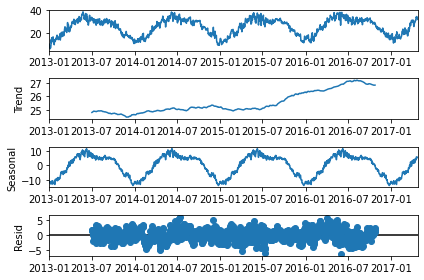

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot();

## Autocorrelação e Estacionariedade

Como a função de auto correlação abaixo não decai  para zero, suspeitamos de que a série não seja estacionária. Vamos verificar a seguir por meio de um teste de hipótese.

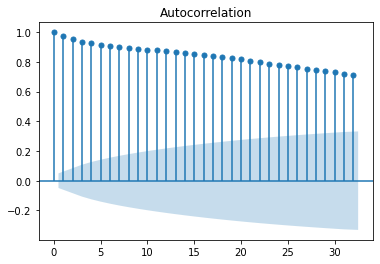

In [10]:
plot_acf(df);

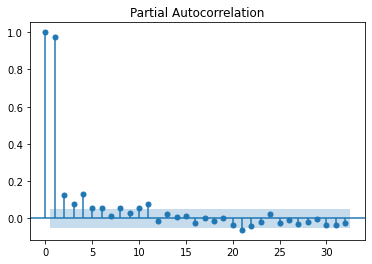

In [11]:
plot_pacf(df);

Considerando um nível de confiança de 0,05 verificamos que o teste de Dickey-Fuller nos leva a não rejeitar a hipótese nula de não estacionariedade, visto que o p-valor = 0,149 (>0,05). Portanto, temos evidências que a série não é estacionária.

In [12]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df)
print(pvalue)
print(lags)

0.14882501558674888
10


## Diferenciação

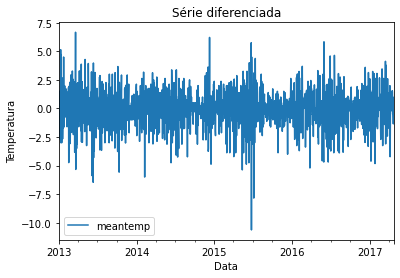

In [13]:
df.diff().plot()
plt.title("Série diferenciada")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

Após diferenciar a série aparenta ser estacionária, vamos verificar com o teste de Dickey-Fuller.

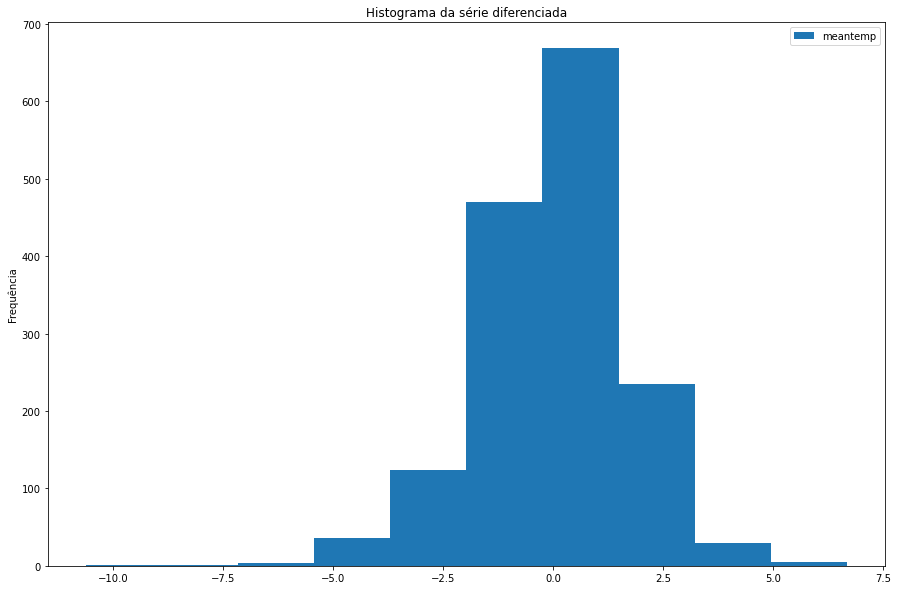

In [14]:
df.diff().plot.hist()
plt.title("Histograma da série diferenciada")
plt.ylabel("Frequência")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [15]:
dfd1 = df.diff().dropna()

Como o p-valor<0,05 então decidimos rejeitar a hipótese nula de não estacionariedade à um nível de confiança de 0,05. Portanto, após diferenciar uma vez a série temos evidências para acreditar que a série se tornou estacionária.

In [16]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1)
print(pvalue)
print(lags)

9.593523131253509e-30
9


## Autocorrelação da série diferenciada

### Correlação

Correlação com série diferenciada

In [17]:
dfd1.corrwith(dfd1.shift(1))

meantemp   -0.156369
dtype: float64

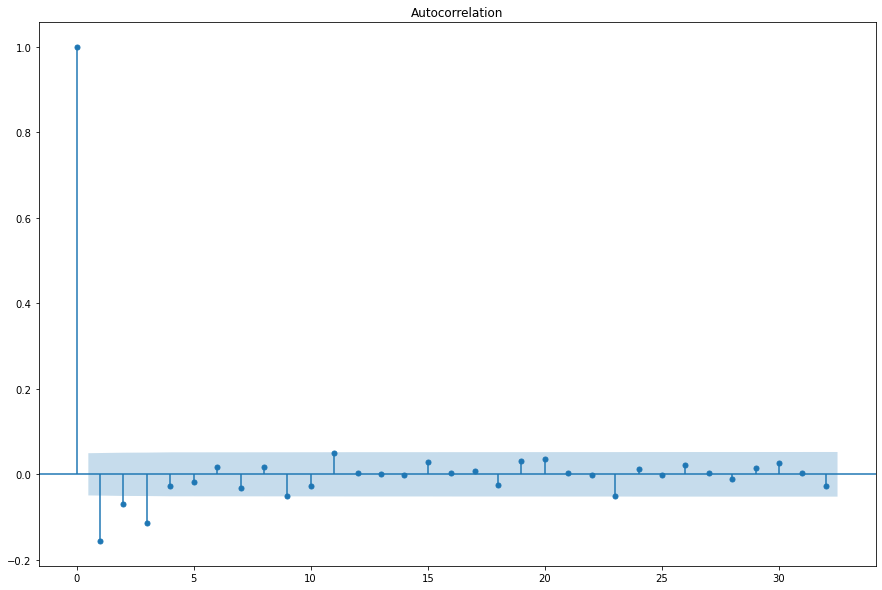

In [18]:
plot_acf(dfd1);

Verificamos a partir do comportamento da função de autocorrelação acima que os lags são significantes até o lag 3, e a partir dele se tornam não significativos. 

## Autocorrelação Parcial

Correlação Parcial com série diferenciada

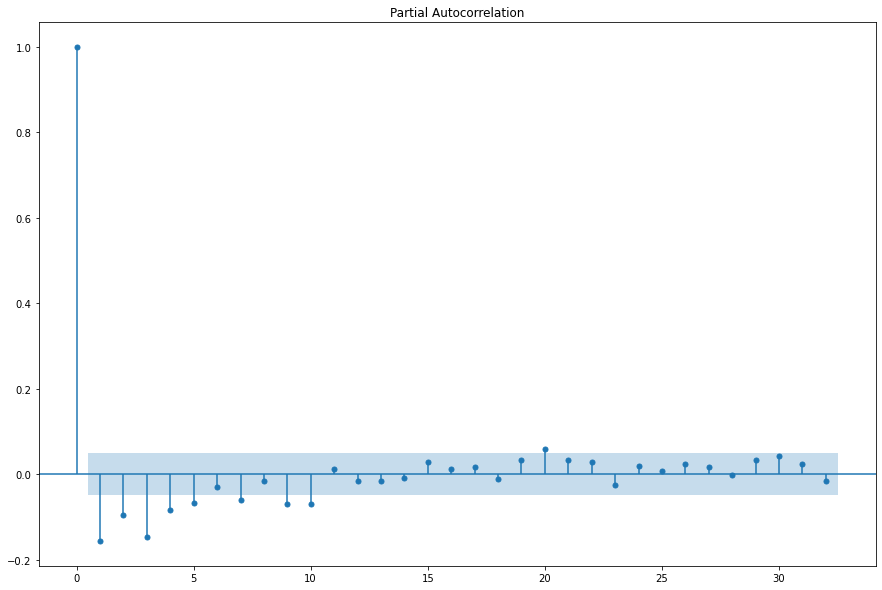

In [19]:
plot_pacf(dfd1);

Verificamos a partir da função de autocorrelação parcial acima que a partir do lag5 os lags se tornam não significativos. Analisando de forma mais conservadora é possível argumentar que o lag5 está bem próximo do limite.

### ARIMA

In [20]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
#df_train.head()

Função para realizar o ajuste dos modelos ARIMA

In [21]:
def perform_arima(p,d,q,data):
    arima_model = ARIMA(data, order=(p,d,q))
    res_arima = arima_model.fit()
    print(res_arima.summary())
    res_arima.plot_diagnostics()
    return res_arima


#### ARIMA (5,1,3)

A partir da analise dos gráficos da função de autocorrelação e autocorrelação parcial decidimos ajustar um ARIMA (5,1,3) visto que a série se torna estacionária após uma diferenciação, há decaimento após lag 3 do gráfico de autocorrelação e também há um corte após o lag 5 do gráfico de autocorrelação parcial.

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2232.011
Date:                Mon, 18 Apr 2022   AIC                           4482.022
Time:                        16:29:15   BIC                           4527.682
Sample:                    01-01-2013   HQIC                          4499.236
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1960      0.071      2.774      0.006       0.058       0.335
ar.L2         -0.7646      0.051    -14.847      0.000      -0.866      -0.664
ar.L3          0.4747      0.095      4.989      0.0

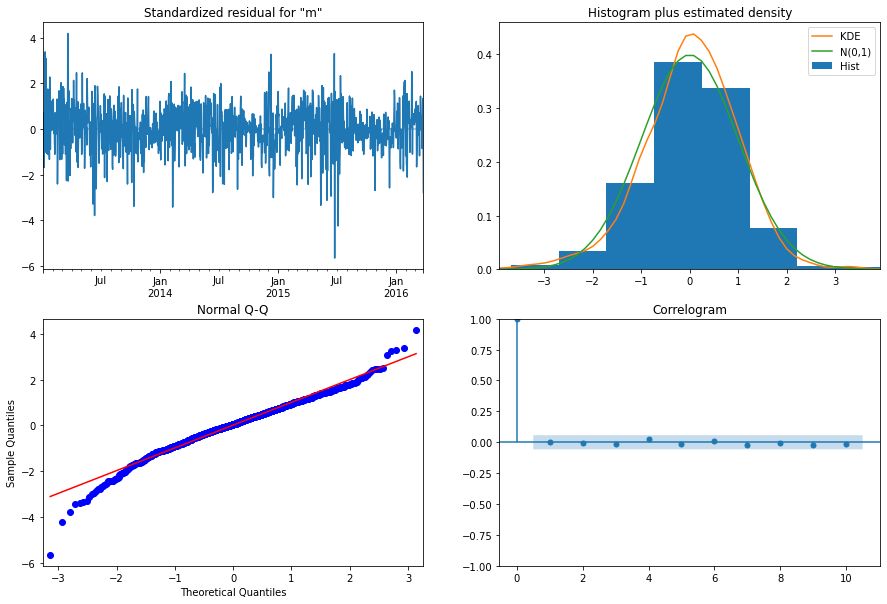

In [22]:
res_arima_1 = perform_arima(5,1,3,df_train)

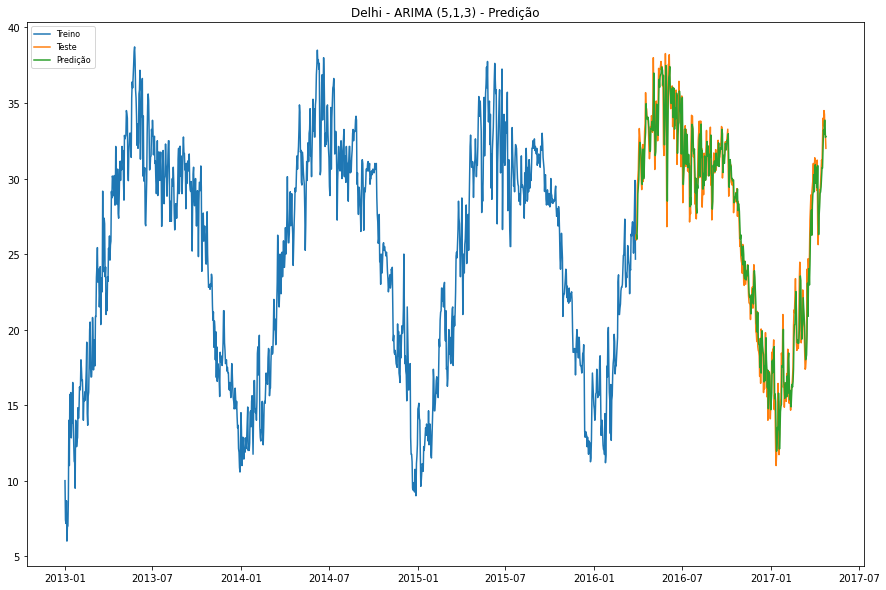

In [23]:
res_arima_1_test = res_arima_1.apply(df_test)
fc = res_arima_1_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (5,1,3) - Predição')

In [24]:
show_metrics(df_test[1:], fc, results, 'ARIMA(5,1,3)')

ARIMA(5,1,3) - model Results
r2 0.9428992824122623
mse 2.567348306435713
mae 1.2289872153389487
mape 0.04923813699013006


{'r2': 0.9428992824122623,
 'mse': 2.567348306435713,
 'mae': 1.2289872153389487,
 'mape': 0.04923813699013006}

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

#### ARIMA (4,1,3)

Também decidimos testar o ARIMA (4,1,3) visto que, com um olhar mais conservador, o corte na função de autocorrelação parcial pode ser visto como no lag 4.

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2232.546
Date:                Mon, 18 Apr 2022   AIC                           4481.092
Time:                        16:29:16   BIC                           4521.678
Sample:                    01-01-2013   HQIC                          4496.393
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1383      0.074     -1.870      0.062      -0.283       0.007
ar.L2         -0.4631      0.072     -6.461      0.000      -0.604      -0.323
ar.L3          0.5214      0.073      7.143      0.0

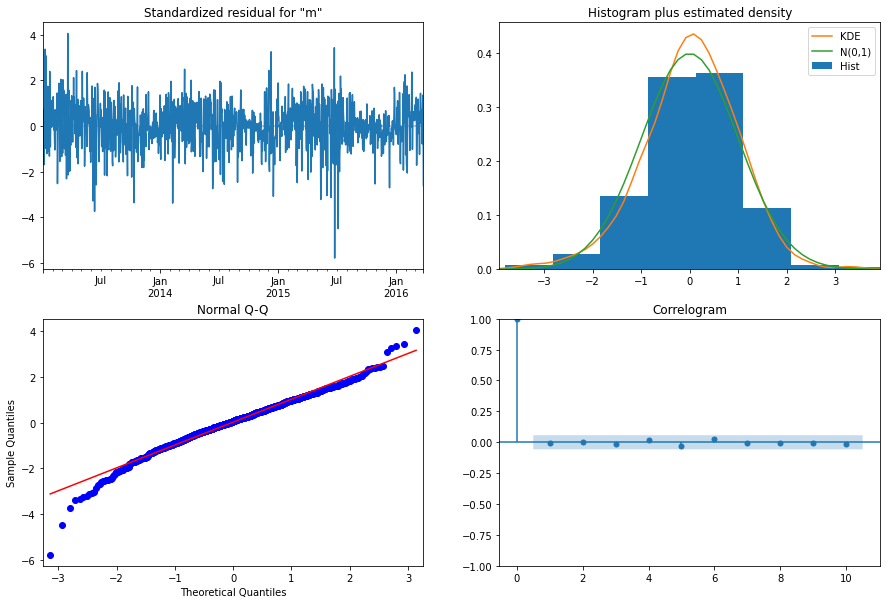

In [25]:
res_arima_2 = perform_arima(4,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

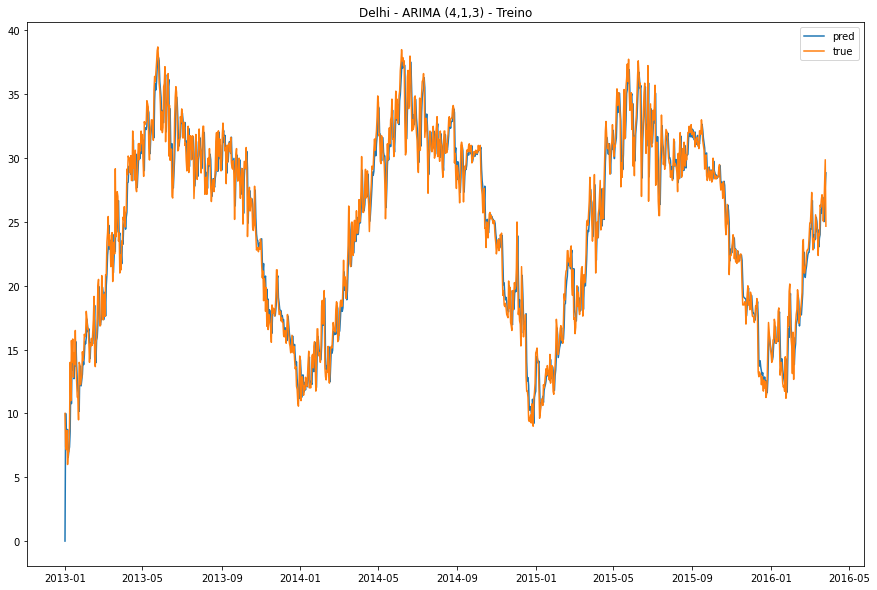

In [26]:
graf_ajuste(res_arima_2.predict(), df_train, 'Delhi - ARIMA (4,1,3) - Treino')

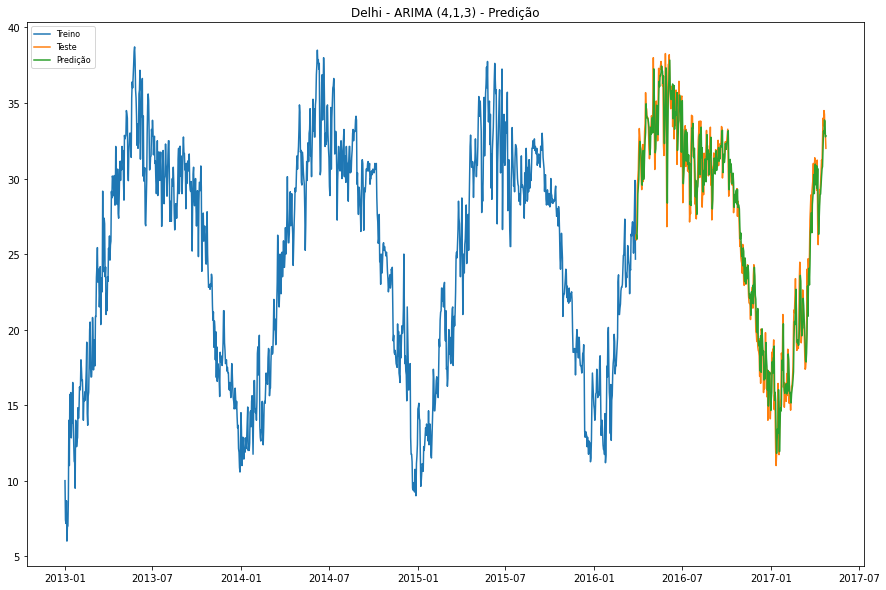

In [27]:
res_arima_2_test = res_arima_2.apply(df_test)
fc = res_arima_2_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (4,1,3) - Predição')

In [28]:
show_metrics(df_test[1:], fc, results, 'ARIMA(4,1,3)')

ARIMA(4,1,3) - model Results
r2 0.9417891684718416
mse 2.6171396138685386
mae 1.24543403506972
mape 0.04961357662209495


{'r2': 0.9417891684718416,
 'mse': 2.6171396138685386,
 'mae': 1.24543403506972,
 'mape': 0.04961357662209495}

#### ARIMA (0,1,3)

Como o comportamento da funções de autocorrelação e autocorrelação parcial em algumas partes não foi tão claro, sem um decaímento exponencial muito evidente, decidimos também avaliar a hipótese de que há o corte brusco na função de autocorrelação, configurando um MA(3), dessa forma avaliamos o modelo ARIMA(0,1,3).

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -2236.505
Date:                Mon, 18 Apr 2022   AIC                           4481.009
Time:                        16:29:18   BIC                           4501.302
Sample:                    01-01-2013   HQIC                          4488.660
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2199      0.025     -8.970      0.000      -0.268      -0.172
ma.L2         -0.1197      0.025     -4.704      0.000      -0.170      -0.070
ma.L3         -0.1432      0.030     -4.837      0.0

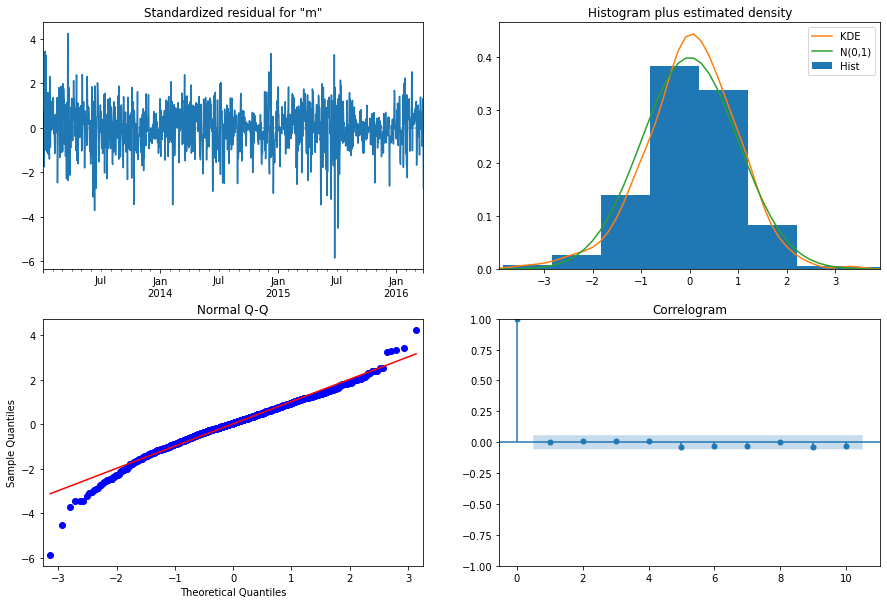

In [29]:
res_arima_3 = perform_arima(0,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

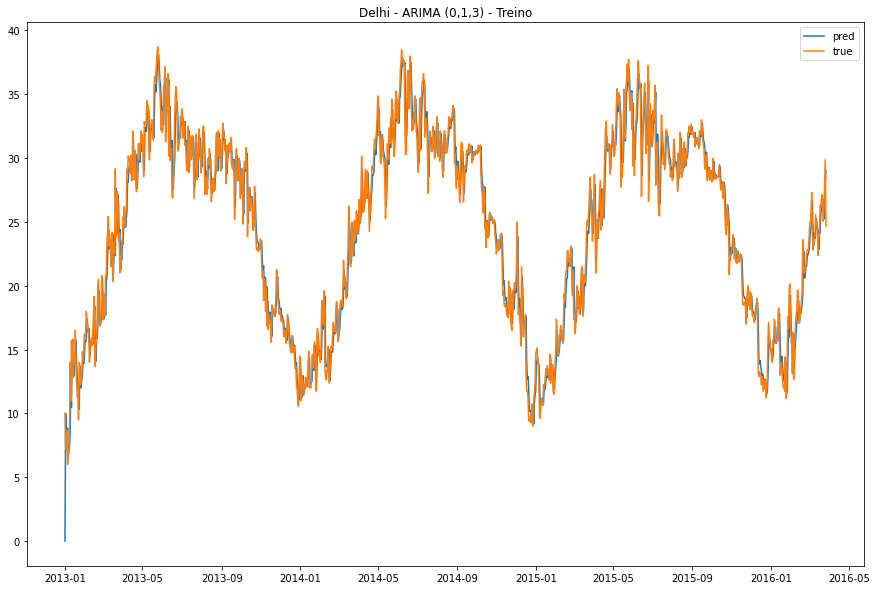

In [30]:
graf_ajuste(res_arima_3.predict(), df_train, 'Delhi - ARIMA (0,1,3) - Treino')

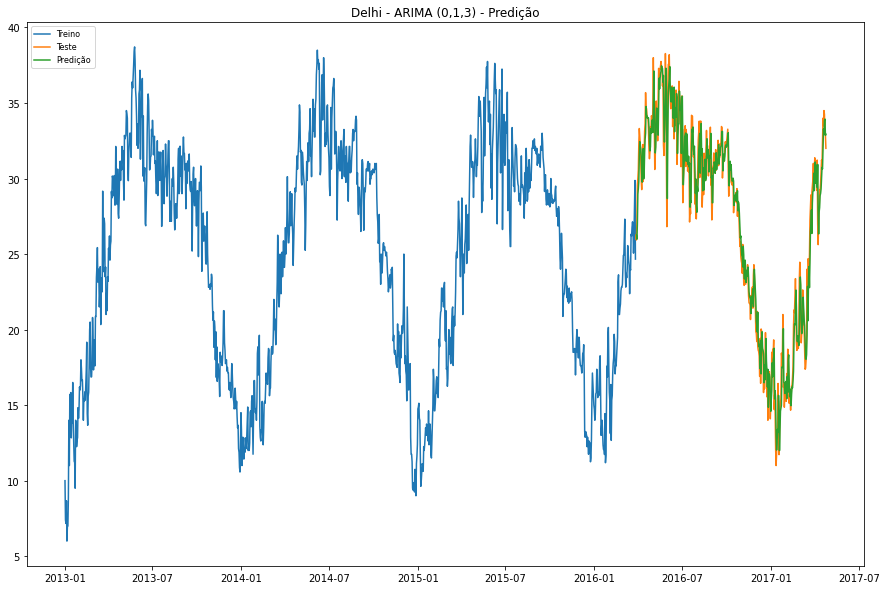

In [31]:
res_arima_3_test = res_arima_3.apply(df_test)
fc = res_arima_3_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (0,1,3) - Predição')

In [32]:
show_metrics(df_test[1:], fc, results, 'ARIMA(0,1,3)')

ARIMA(0,1,3) - model Results
r2 0.9425815257205067
mse 2.5840690325055573
mae 1.2380173098922034
mape 0.04958577543716851


{'r2': 0.9425815257205067,
 'mse': 2.5840690325055573,
 'mae': 1.2380173098922034,
 'mape': 0.04958577543716851}

### Auto ARIMA

In [33]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True) #verificar forcar estacionario

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4494.045, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11018.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9511.186, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4512.618, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4492.004, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4531.154, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4493.975, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4489.732, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4523.647, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4531.821, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4491.714, 

O Auto ARIMA nos informa que, dentre os modelos testados, o ARIMA (2,0,1) é o modelo com o menor AIC (Critério de Informação de Akaike)

In [34]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2239.866
Date:                Mon, 18 Apr 2022   AIC                           4489.732
Time:                        16:29:26   BIC                           4515.102
Sample:                             0   HQIC                          4499.296
                               - 1181                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0506      0.030      1.672      0.094      -0.009       0.110
ar.L1          1.5616      0.055     28.192      0.000       1.453       1.670
ar.L2         -0.5638      0.055    -10.282      0.000      -0.671      -0.456
ma.L1         -0.7881      0.045    -17.488      0.000      -0.876      -0.700
sigma2         2.5920      0.086     30.135      0.000       2.423       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               227.00
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.46
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

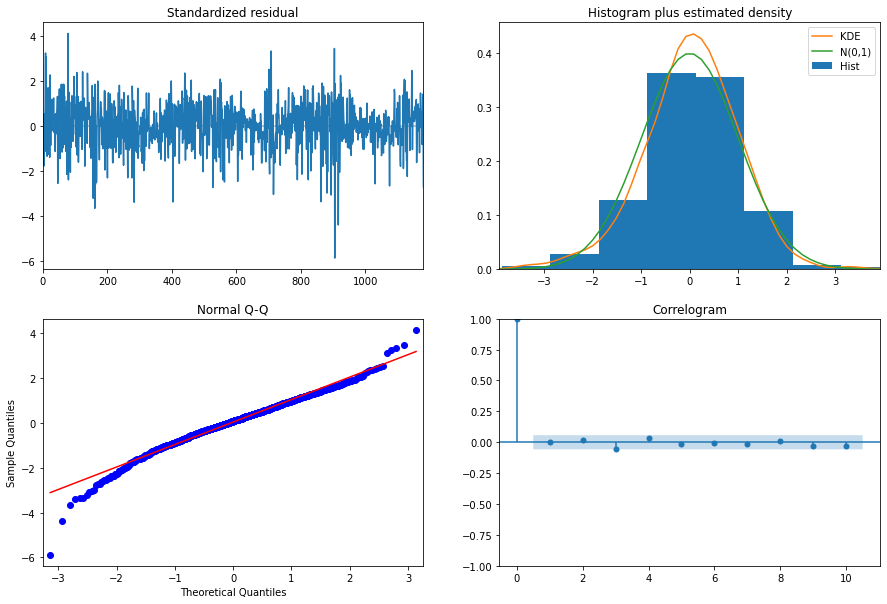

In [35]:
auto_arima.plot_diagnostics();

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

Plotando ajuste do modelo aos dados de treino

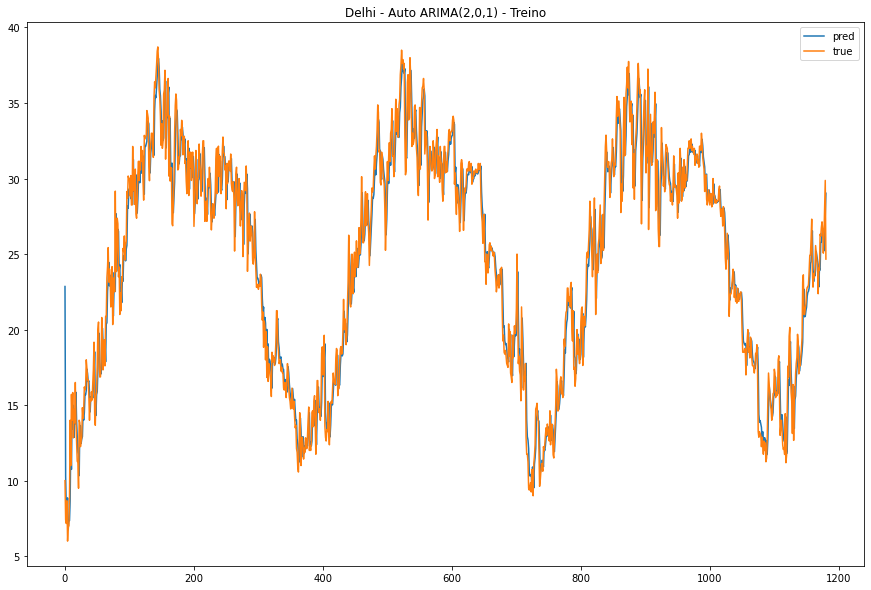

In [36]:
graf_ajuste(auto_arima.predict_in_sample(), df_train.values, 'Delhi - Auto ARIMA(2,0,1) - Treino')

Plotando Treino, teste e predição

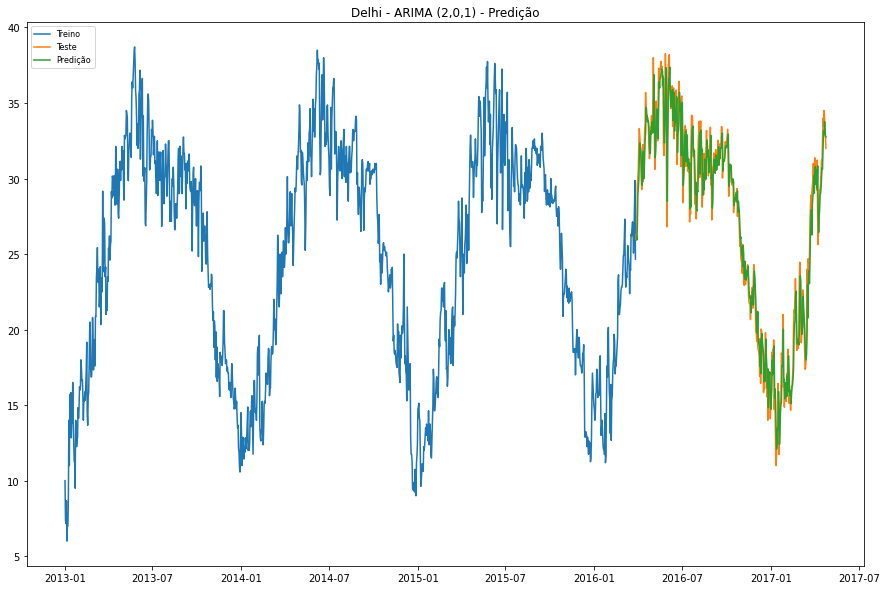

In [37]:
auto_model = ARIMA(df_train, order=(2, 0, 1))  
res_arima_4 = auto_model.fit()
res_arima_4_test = res_arima_4.apply(df_test)
fc = res_arima_4_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (2,0,1) - Predição')

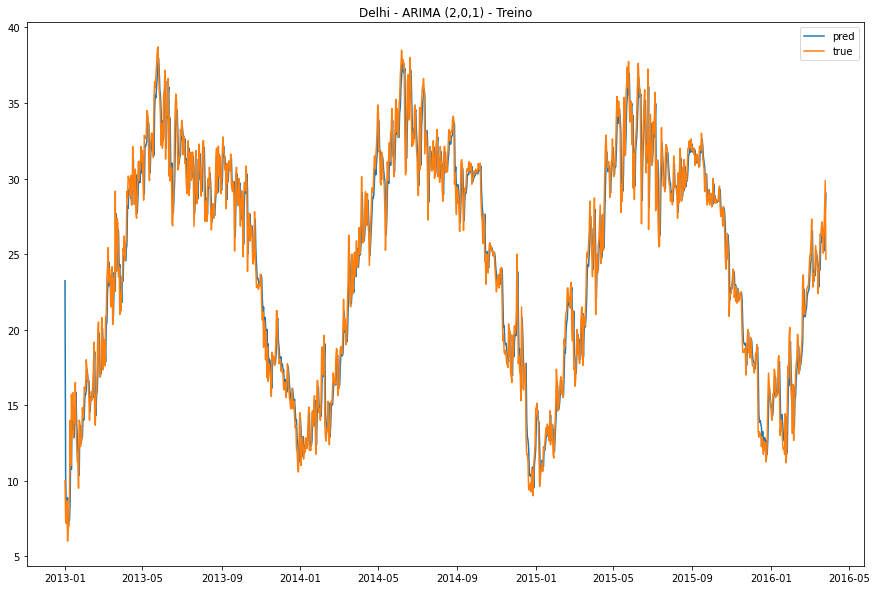

In [38]:
graf_ajuste(res_arima_4.predict(), df_train, 'Delhi - ARIMA (2,0,1) - Treino')

In [39]:
show_metrics(df_test[1:], fc, results, 'ARIMA(2,0,1)')

ARIMA(2,0,1) - model Results
r2 0.9415400697365356
mse 2.575905762658586
mae 1.2381615862885729
mape 0.049452803715893716


{'r2': 0.9415400697365356,
 'mse': 2.575905762658586,
 'mae': 1.2381615862885729,
 'mape': 0.049452803715893716}

## Machine Learning

Foram gerados modelos utilizando três métodos de ML (KNN, SVR e MLP). Espera-se que com estes métodos seja possível capturar também relações não lineares existentes na série.

### Feature Engineering

Primeiramente, foi necessário realizar feature engineering no dados da série a fim de criar features relevantes para os modelos.

Foi utilizada a função **get_lags**, a qual cria features que correspodem a atrasos da série temporal. O número de atrasos  pode ser determinado a partir da análise do correlograma utilizando a quantidade de lags correlacionados.

In [40]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

Decidimos utilizar o número de lags 3, assim foram criadas 5 novas features com os atrasos para a série.

In [41]:
X = get_lags(df, 3)
X.head()

meantemp-1  meantemp-2  meantemp-3
date                                          
2013-01-04    7.166667    7.400000   10.000000
2013-01-05    8.666667    7.166667    7.400000
2013-01-06    6.000000    8.666667    7.166667
2013-01-07    7.000000    6.000000    8.666667
2013-01-08    7.000000    7.000000    6.000000

In [42]:
y = df.reindex(X.index)
y.head()

meantemp
date                
2013-01-04  8.666667
2013-01-05  6.000000
2013-01-06  7.000000
2013-01-07  7.000000
2013-01-08  8.857143

### Separando os dados

Os dados foram separados em treino e teste, para serem utilizado no GridSearch. Como o ScikitLearn separa os dados de validação, o conjunto de teste abaixo já contém o conjunto de validação.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

Utilizamos o GridSearch para encontrar os melhores parâmetros para o KNN. Foram utilizados dois hiperâmetros: o número de vizinhos(n_neighbors) e o peso (weights). 

In [44]:
#Definindo hiperpâmetros de busca do GridSearch
parameters = {'n_neighbors':range(1,20), 'weights':["uniform", "distance"]}
for p in parameters.items():
  print(p)

('n_neighbors', range(1, 20))
('weights', ['uniform', 'distance'])


In [45]:
knn = KNeighborsRegressor()
knnGS = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_percentage_error', cv=TimeSeriesSplit(n_splits=2, test_size=round(len(df)*0.25)))
res = knnGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)

-0.05953256301379137
{'n_neighbors': 11, 'weights': 'uniform'}


Métricas

In [46]:
prediction = res.predict(X_test)
show_metrics(y_test, prediction, results, 'KNN GS')

KNN GS - model Results
r2 0.9320076561008203
mse 2.8812950903273653
mae 1.3183498907032154
mape 0.05226412226090598


{'r2': 0.9320076561008203,
 'mse': 2.8812950903273653,
 'mae': 1.3183498907032154,
 'mape': 0.05226412226090598}

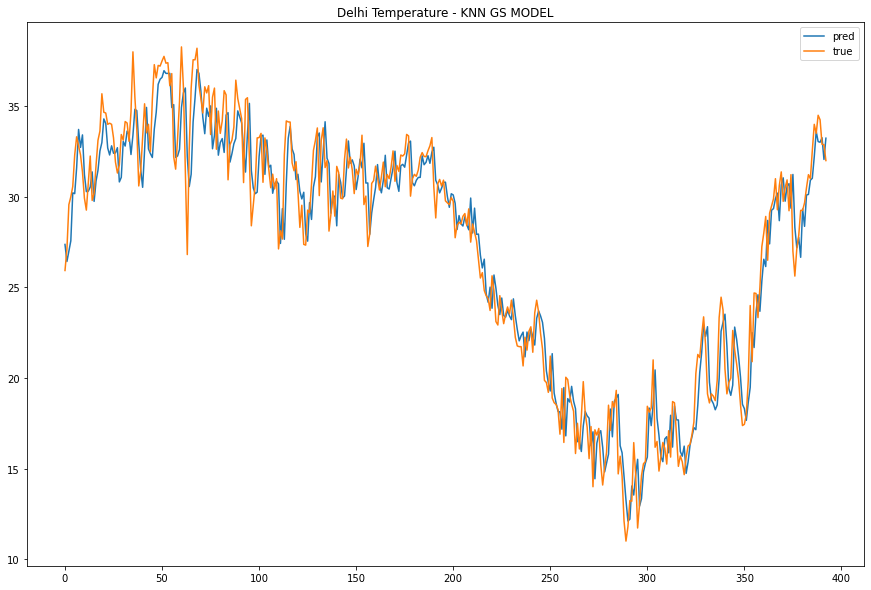

In [47]:
graf_ajuste(prediction, y_test.reset_index(drop=True), 'Delhi Temperature - KNN GS MODEL')


<AxesSubplot:>

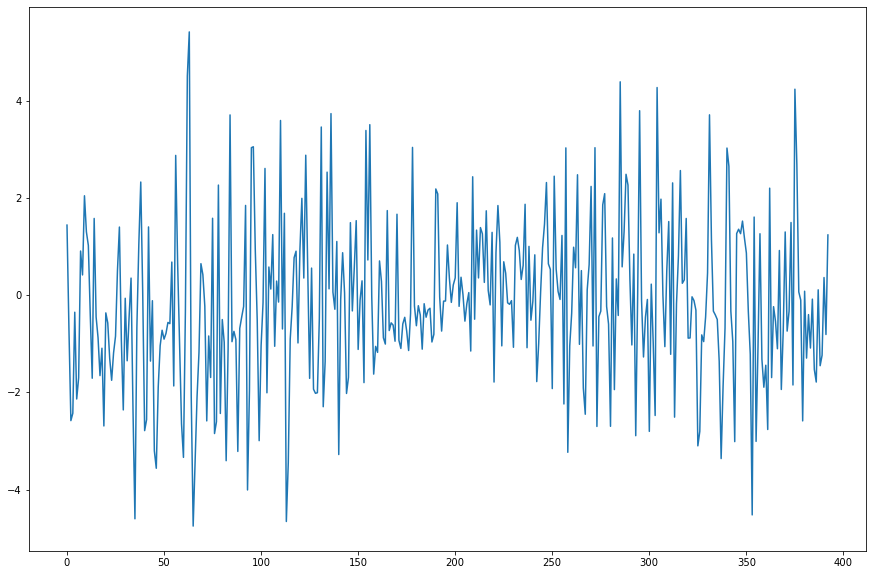

In [48]:
residuos = prediction.flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

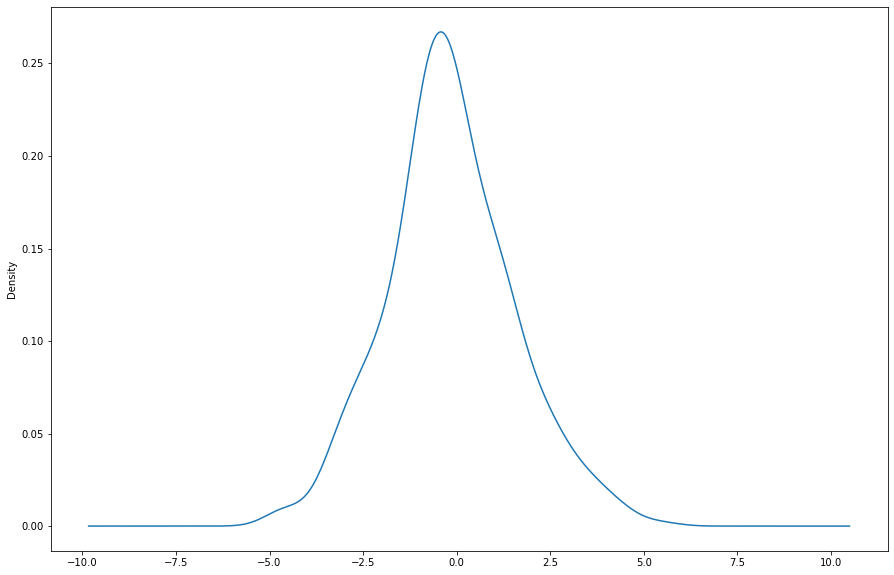

In [49]:
pd.Series(residuos).plot.kde()

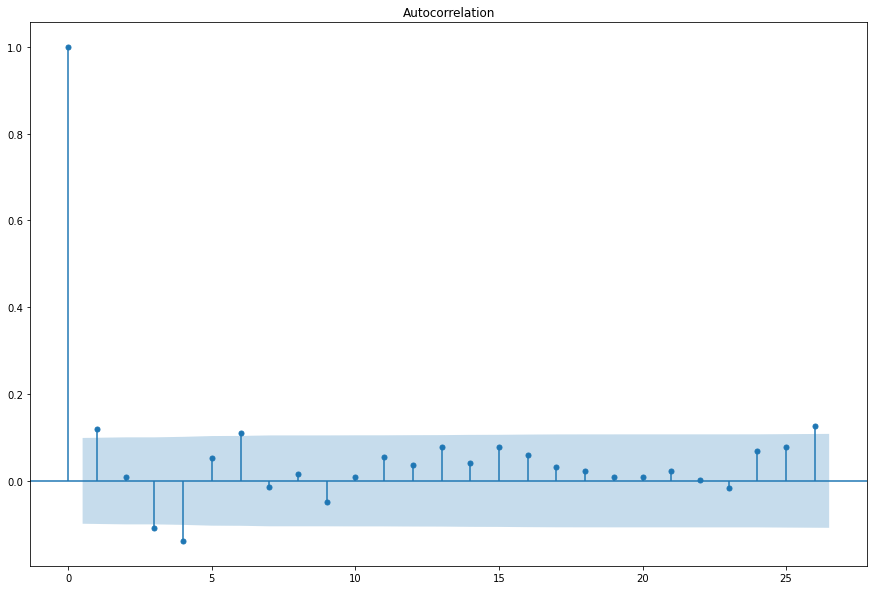

In [50]:
plot_acf(residuos);

Acima verificamos que o modelo se ajustou bem aos valores reais de acordo com as métricas. No entanto, abaixo foi feito o KNN com a série diferenciada a fim de verificar se há possibilidade de conseguir melhores valores. 

#### KNN com série difenciada

In [51]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [52]:
res_diff = knnGS.fit(X_train_d1, y_train_d1)
print(res_diff.best_score_)
print(res_diff.best_params_)

-53877960039131.516
{'n_neighbors': 19, 'weights': 'uniform'}


In [53]:
prediction_diff = res_diff.predict(X_test_d1)
show_metrics(y_test_d1, prediction_diff, results, 'd1 KNN GS')

d1 KNN GS - model Results
r2 -11.389823715917856
mse 2.803505803126002
mae 1.2705385875891515
mape 9.010178035499667


{'r2': -11.389823715917856,
 'mse': 2.803505803126002,
 'mae': 1.2705385875891515,
 'mape': 9.010178035499667}

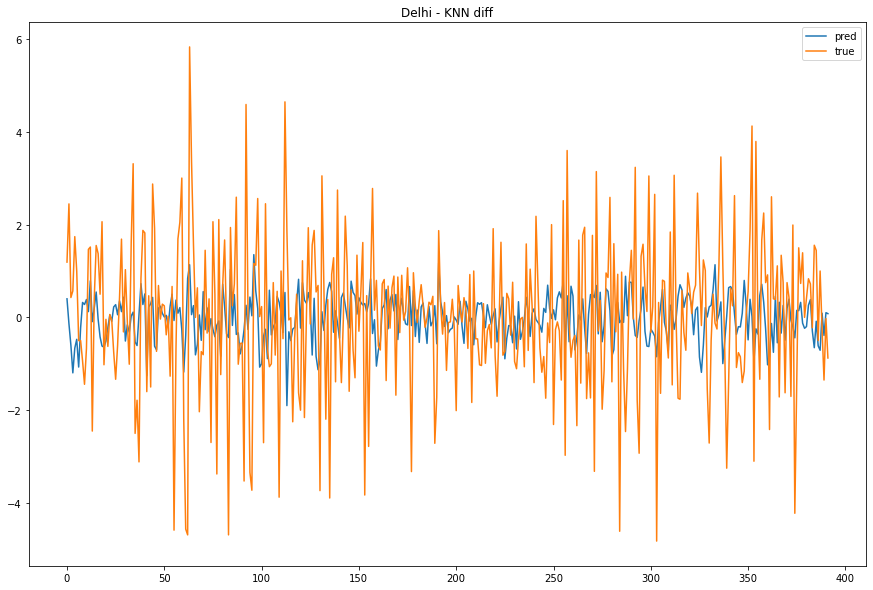

In [54]:
graf_ajuste(pd.Series(prediction_diff.flatten()), y_test_d1.reset_index(drop=True), 'Delhi - KNN diff')

In [55]:
residuos = prediction_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()

<AxesSubplot:>

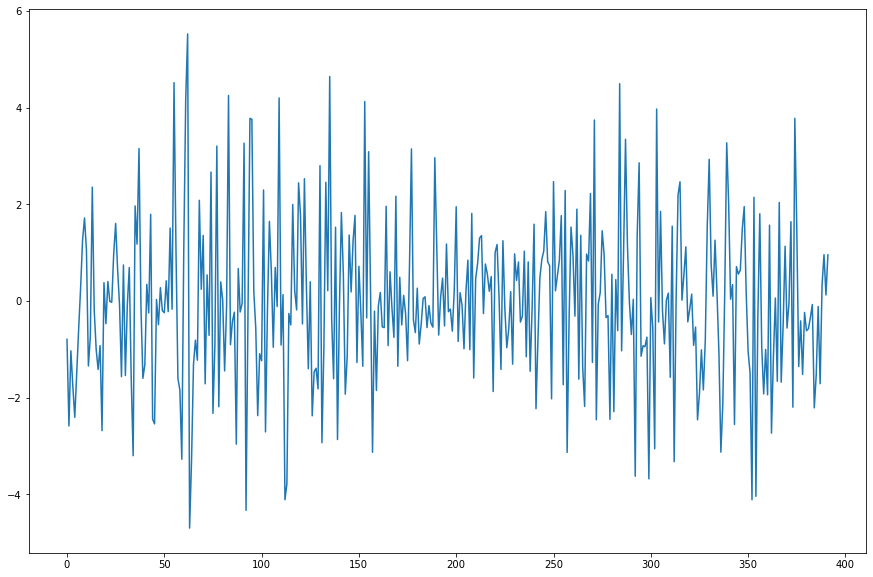

In [56]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

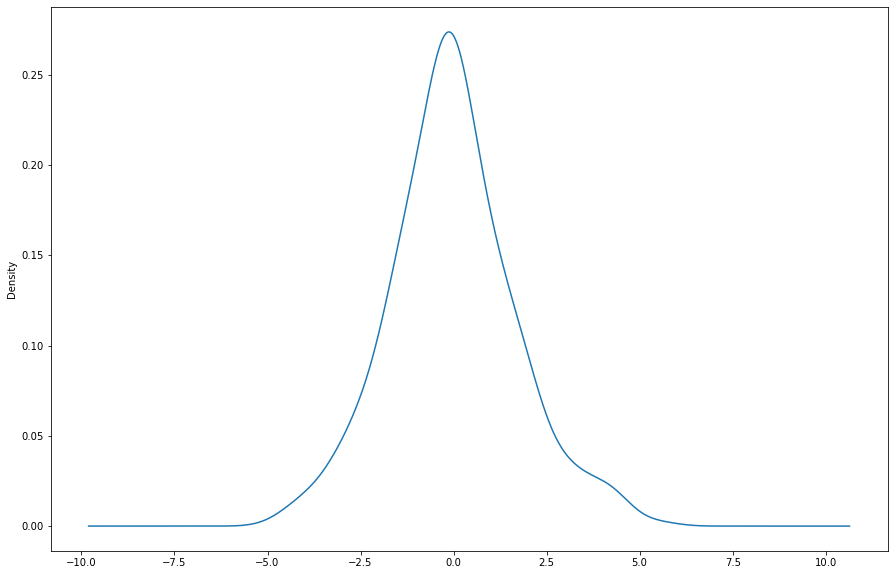

In [57]:
pd.Series(residuos).plot.kde()

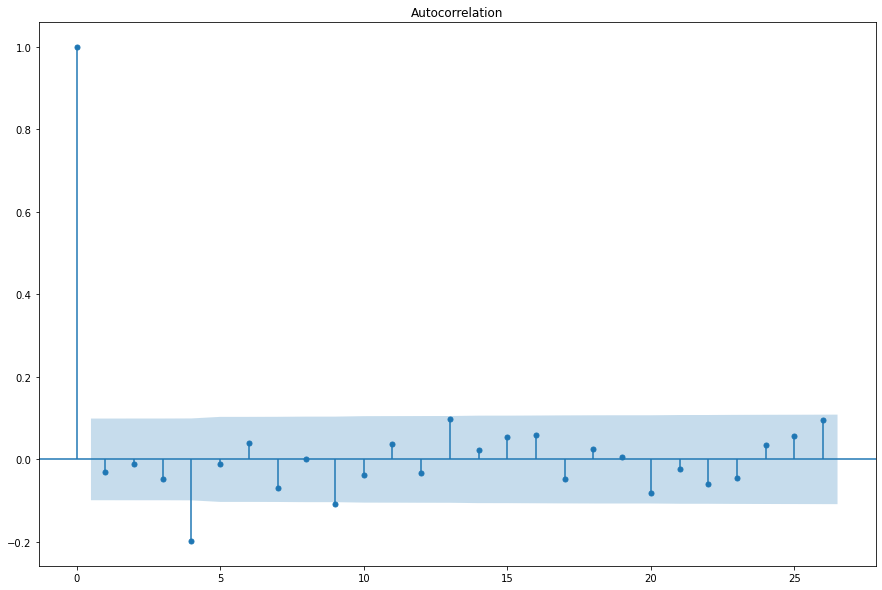

In [58]:
plot_acf(residuos);

One step 


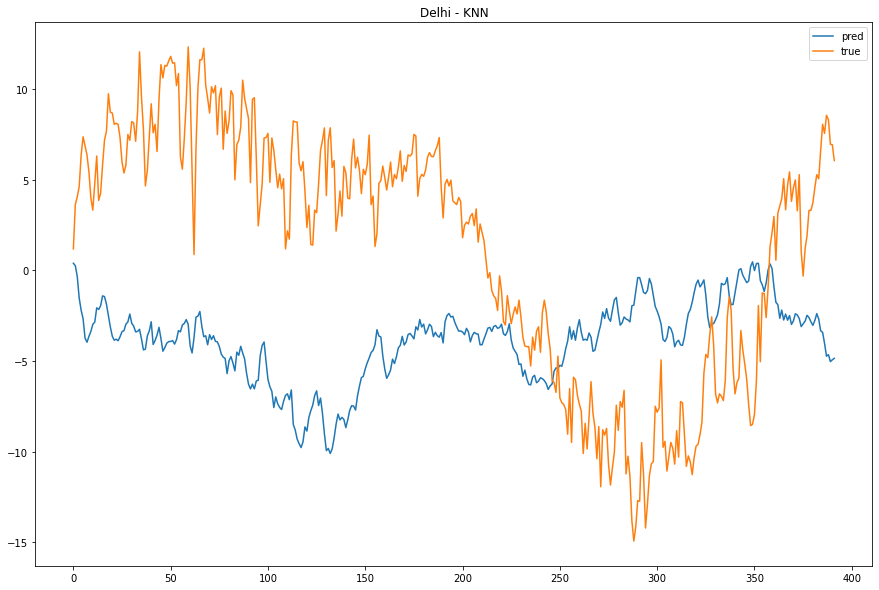

In [59]:
graf_ajuste(pd.Series(prediction_diff.flatten()).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi - KNN')

Como o gráfico apresentou pouco ajuste ao valor real, decidimos utilizar o valor real para ajustar a predição. 

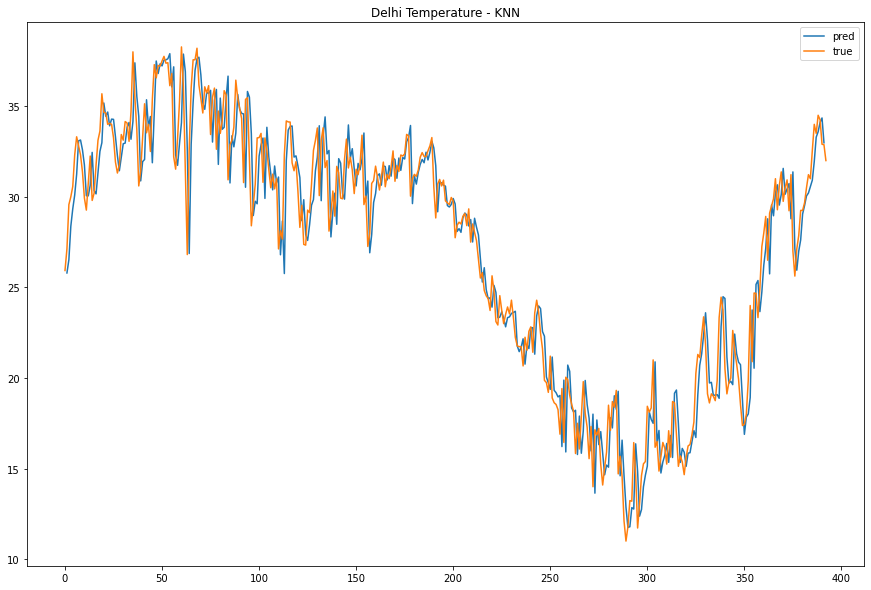

In [60]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(prediction_diff.flatten(), name='temperature'),axis=0)
graf_ajuste(pred_one, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [61]:
show_metrics(y_test.iloc[1:-1], pred_one.iloc[1:-1], results, 'pred one KNN GS')

pred one KNN GS - model Results
r2 0.9235788698911865
mse 3.5343718064366194
mae 1.407424186259793
mape 0.0568522480089041


{'r2': 0.9235788698911865,
 'mse': 3.5343718064366194,
 'mae': 1.407424186259793,
 'mape': 0.0568522480089041}

<AxesSubplot:>

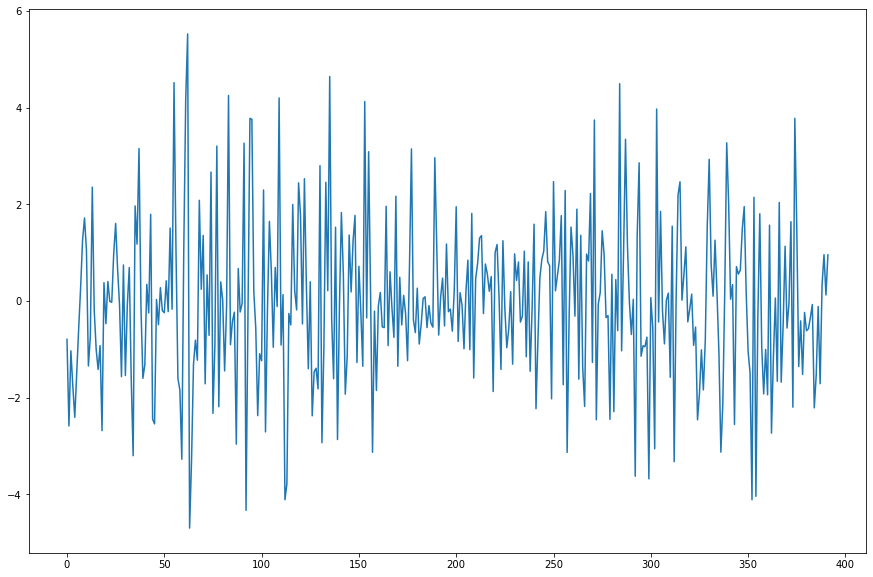

In [62]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

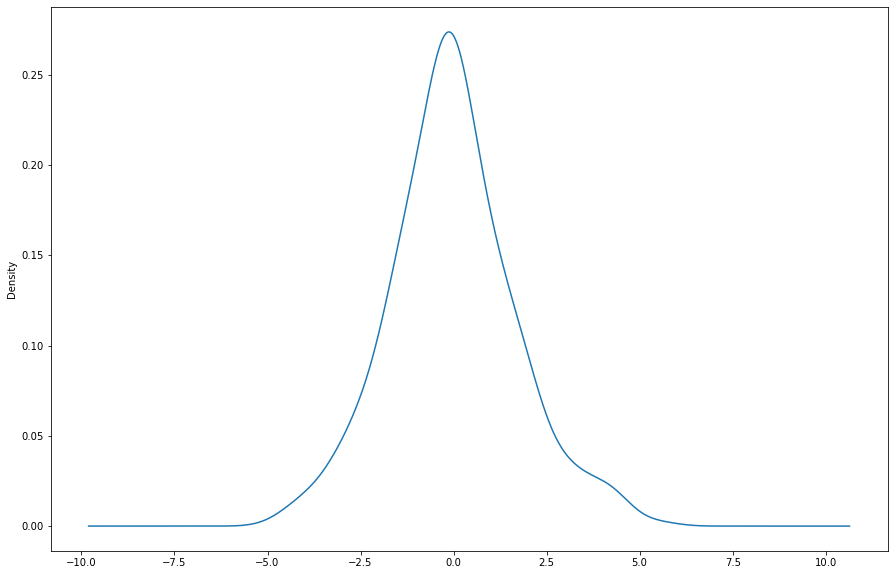

In [63]:
pd.Series(residuos).plot.kde()

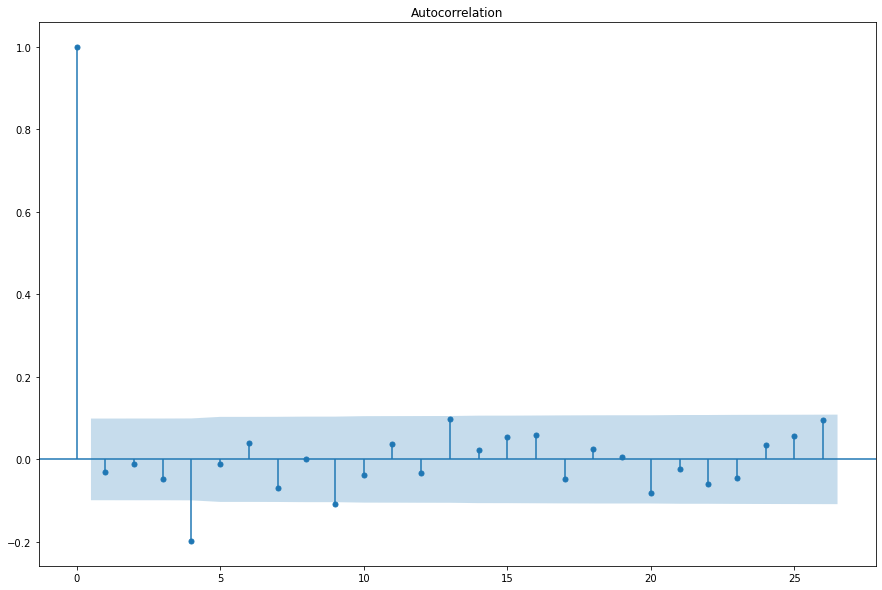

In [64]:
plot_acf(residuos);

Ao final do experimento com o KNN, verificamos que foi possível obter melhores resultados com a série diferenciada. No entanto, foi necessário a utilização de valores reais para o ajuste da tendência da série.

### Support Vector Regression

Aqui utilizaremos o Support Vector Regression, primeiro vamos ajustar um modelo simples e depois tentar melhorar os parâmetros com o uso do GridSearch.

In [65]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

regr.fit(X_train, y_train)

SVR(epsilon=0.2, kernel='linear')

In [66]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR')

SVR - model Results
r2 0.9408686653844883
mse 2.687918103370144
mae 1.2422099872240857
mape 0.049587777671510944


{'r2': 0.9408686653844883,
 'mse': 2.687918103370144,
 'mae': 1.2422099872240857,
 'mape': 0.049587777671510944}

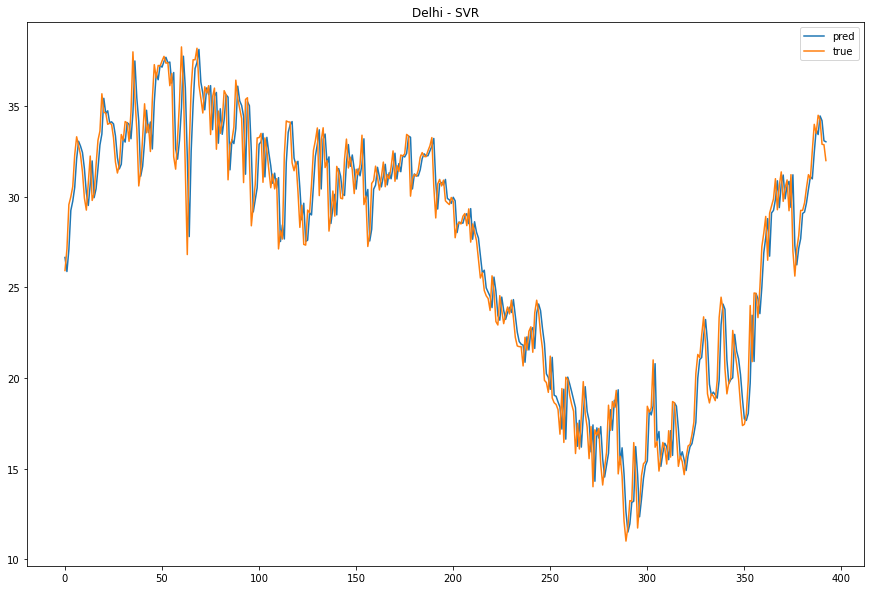

In [67]:
graf_ajuste(regr.predict(X_test), y_test.reset_index(drop=True), 'Delhi - SVR')

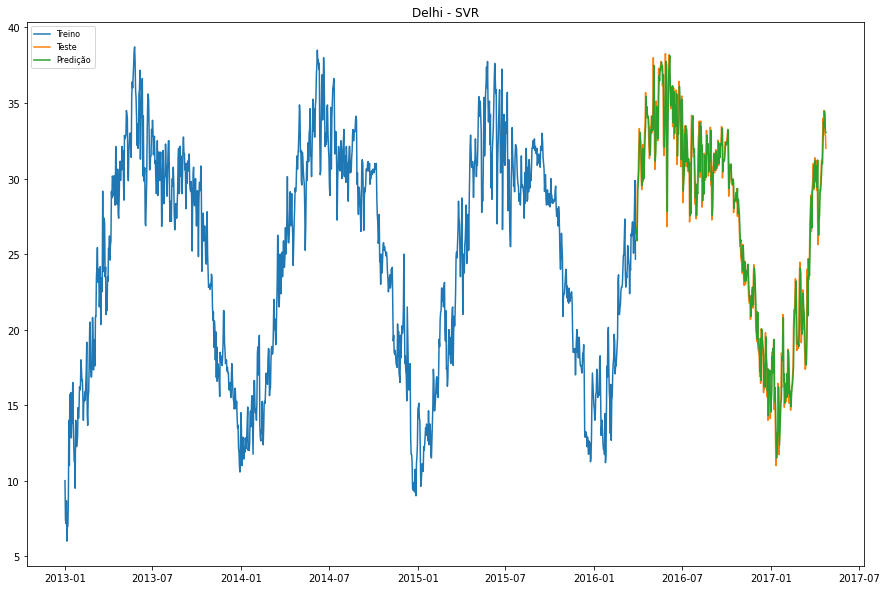

In [68]:
graf_pred(regr.predict(X_test), df_train, df_test, 'Delhi - SVR', SVR=True)

Verificamos que o modelo ajustou muito bem aos dados e fez predições do conjunto de teste muito próximas dos valores reais, como podemos verificar nos gráficos acima e nas métricas de avaliação.

#### Grid Search

Agora vamos utilizar o GridSearch para explorar diferentes parâmetros e do SVR e encontrar os melhores.

In [69]:
parameters = {'kernel':['linear','rbf', 'sigmoid', 'polynomial'], 
              'C':np.linspace(0.05, 10, 20),
              'gamma':np.linspace(.1, 10, 3),
              'coef0':np.linspace(.01, 10, 3),
              'degree':np.arange(2, 3)
              }

for p in parameters.items():
  print(p)

('kernel', ['linear', 'rbf', 'sigmoid', 'polynomial'])
('C', array([ 0.05      ,  0.57368421,  1.09736842,  1.62105263,  2.14473684,
        2.66842105,  3.19210526,  3.71578947,  4.23947368,  4.76315789,
        5.28684211,  5.81052632,  6.33421053,  6.85789474,  7.38157895,
        7.90526316,  8.42894737,  8.95263158,  9.47631579, 10.        ]))
('gamma', array([ 0.1 ,  5.05, 10.  ]))
('coef0', array([ 0.01 ,  5.005, 10.   ]))
('degree', array([2]))


In [70]:
regr2 = SVR()
regrGS = GridSearchCV(regr2, parameters, scoring='neg_mean_absolute_percentage_error', cv=TimeSeriesSplit(n_splits=2, test_size=round(len(df)*0.25)))

In [71]:
res = regrGS.fit(X_train, y_train)

Após executar o GridSearch obtivemos como melhor score e parâmetros:

In [72]:
print(res.best_score_)
print(res.best_params_)

#{'C': 10.0, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}

-0.05255373964671359
{'C': 10.0, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}


In [73]:
regr2 = SVR(C=10, kernel='linear')
res = regr2.fit(X_train, y_train)

In [74]:
forecast = regr2.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GS')

SVR GS - model Results
r2 0.9409015286501162
mse 2.6912135038192915
mae 1.2422339126675814
mape 0.04959064613330293


{'r2': 0.9409015286501162,
 'mse': 2.6912135038192915,
 'mae': 1.2422339126675814,
 'mape': 0.04959064613330293}

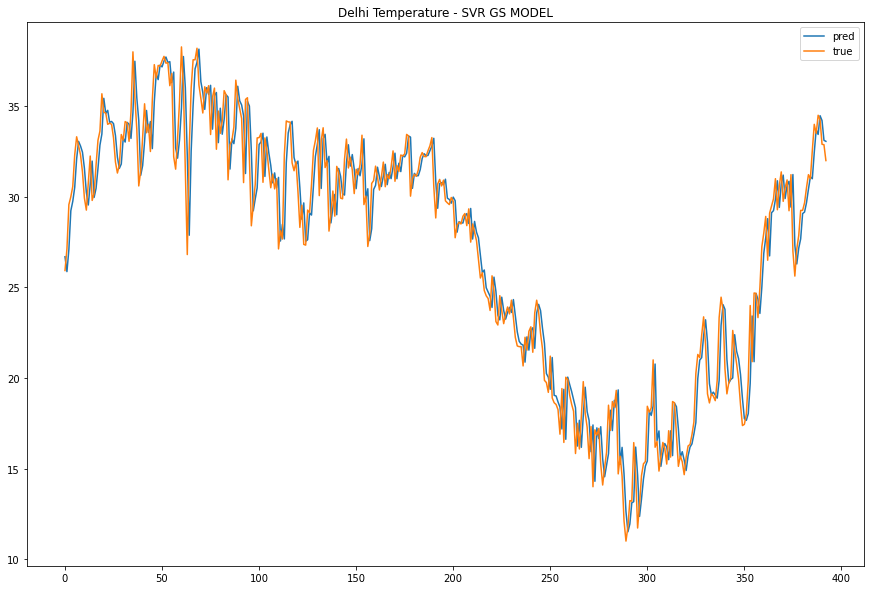

In [75]:
graf_ajuste(res.predict(X_test), y_test.reset_index(drop=True), 'Delhi Temperature - SVR GS MODEL')

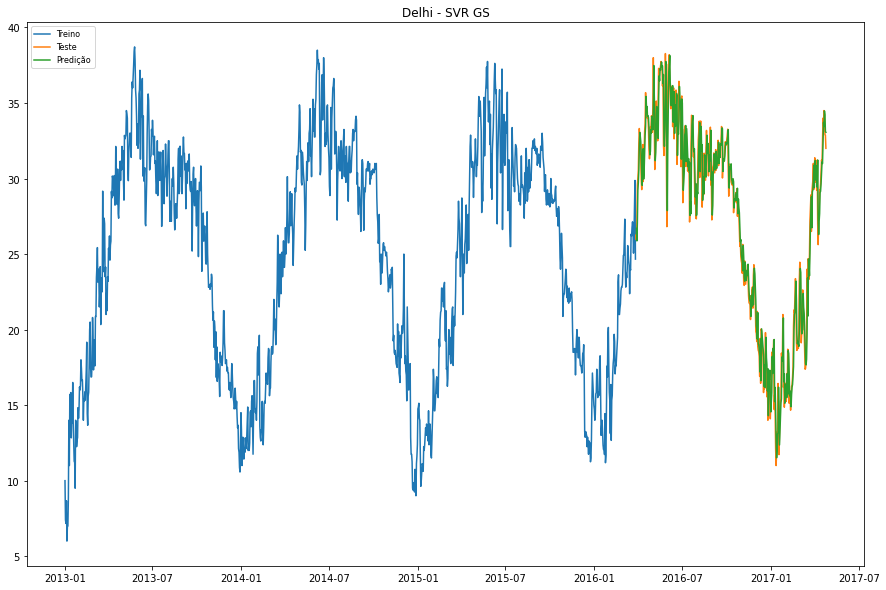

In [76]:
graf_pred(res.predict(X_test), df_train, df_test, 'Delhi - SVR GS', SVR=True)

<AxesSubplot:>

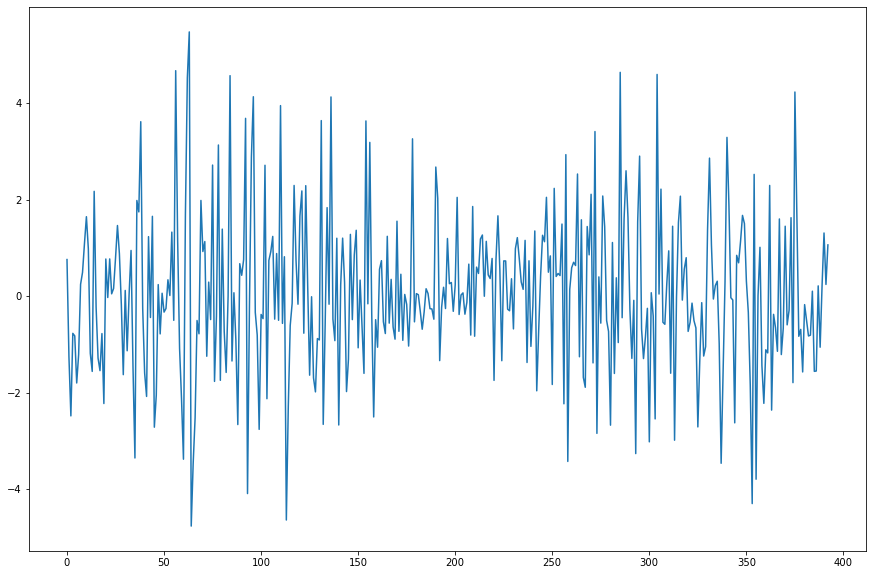

In [77]:
residuos = res.predict(X_test).flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

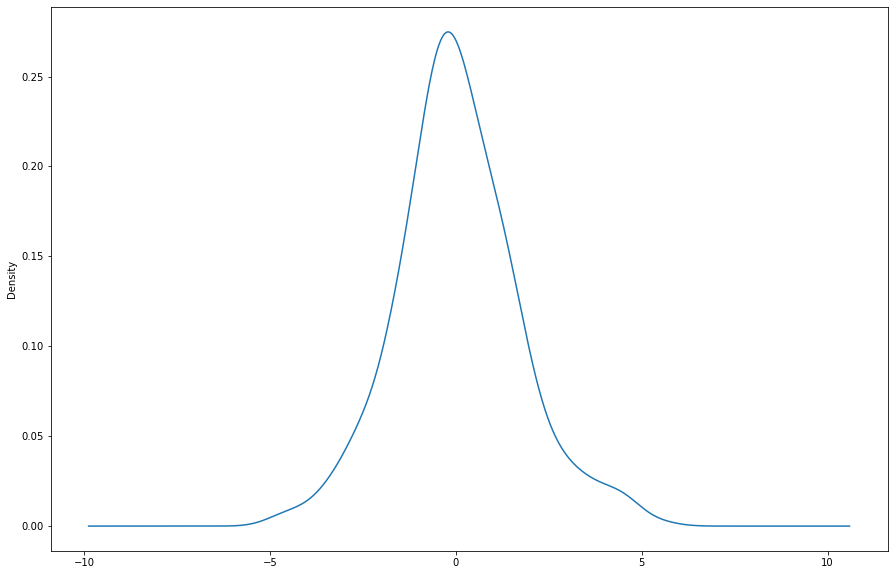

In [78]:
pd.Series(residuos).plot.kde()

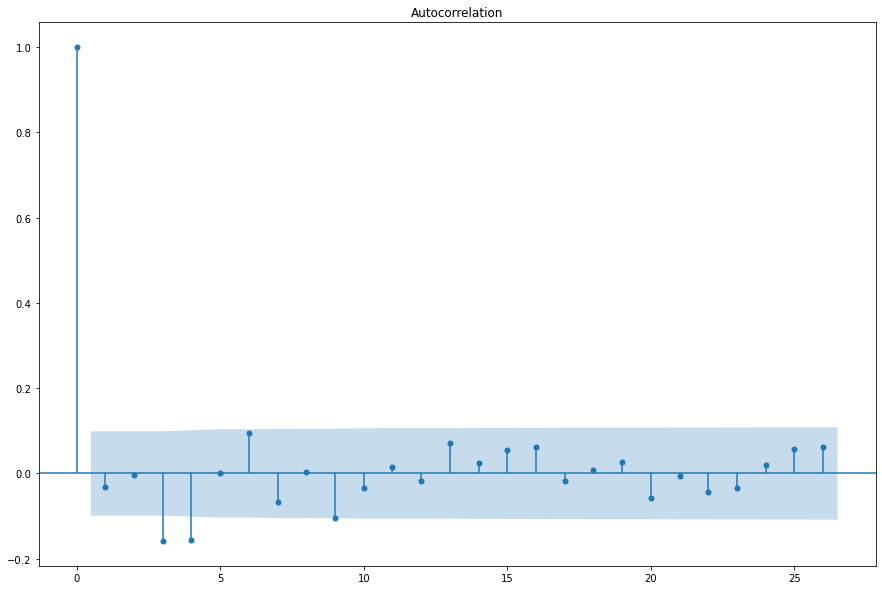

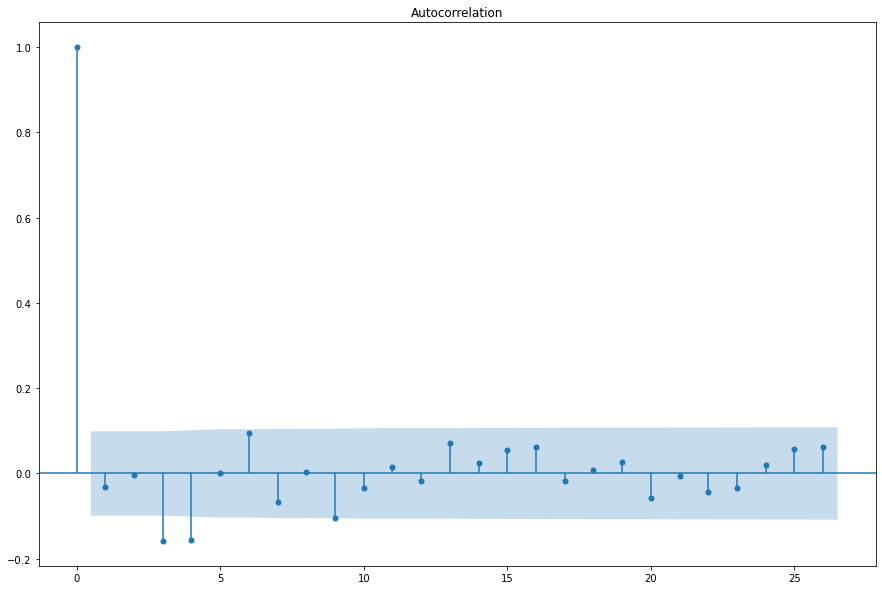

In [79]:
plot_acf(residuos)

Verificando Overfitting

In [80]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

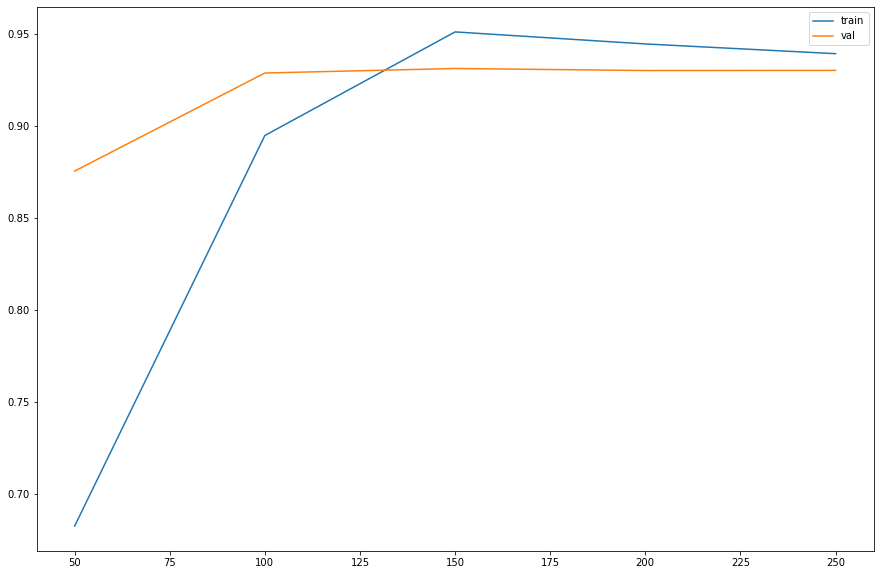

In [81]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

A partir do gráfico acima não aparenta haver Overfit.

#### SVR com Serie diferenciada

In [82]:
regr2d1 = SVR()
regrGSd1 = GridSearchCV(regr2d1, parameters, scoring='neg_mean_absolute_percentage_error', cv=TimeSeriesSplit(n_splits=2, test_size=round(len(df)*0.25)))

res = regrGSd1.fit(X_train_d1, y_train_d1)

In [83]:
print(res.best_score_)
print(res.best_params_)

-5370262764404.213
{'C': 1.0973684210526315, 'coef0': 5.005, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}


In [84]:
regr2d1 = SVR(C=1.0973, kernel='sigmoid', coef0=5.005)
res = regr2d1.fit(X_train_d1, y_train_d1)

In [85]:
forecast_diff = regr2d1.predict(X_test_d1)
show_metrics(y_test_d1, forecast_diff, results, 'SVR d1')

SVR d1 - model Results
r2 -0.8525103571668793
mse 5.741806465912029
mae 1.5646827292305292
mape 12.45490265215911


{'r2': -0.8525103571668793,
 'mse': 5.741806465912029,
 'mae': 1.5646827292305292,
 'mape': 12.45490265215911}

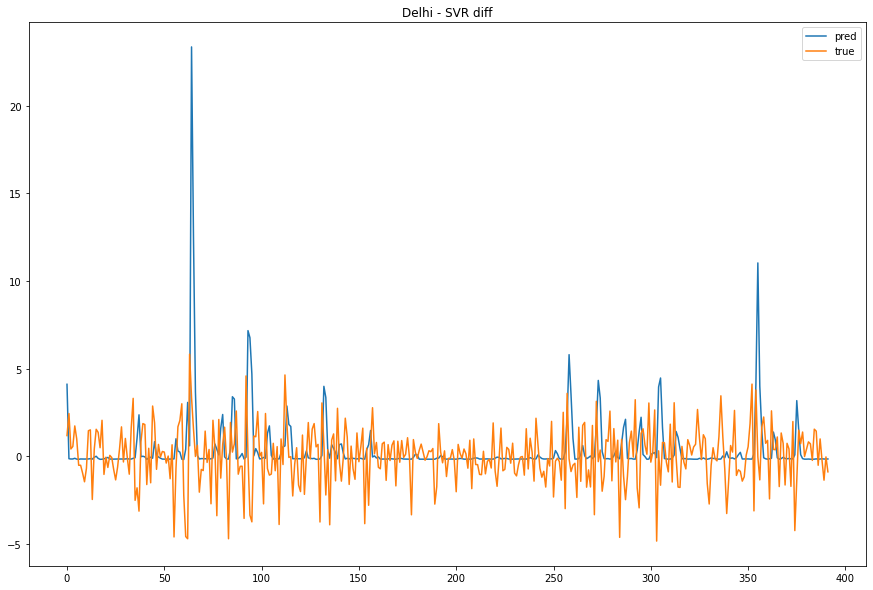

In [86]:
graf_ajuste(pd.Series(forecast_diff.flatten()), y_test_d1.reset_index(drop=True), 'Delhi - SVR diff')

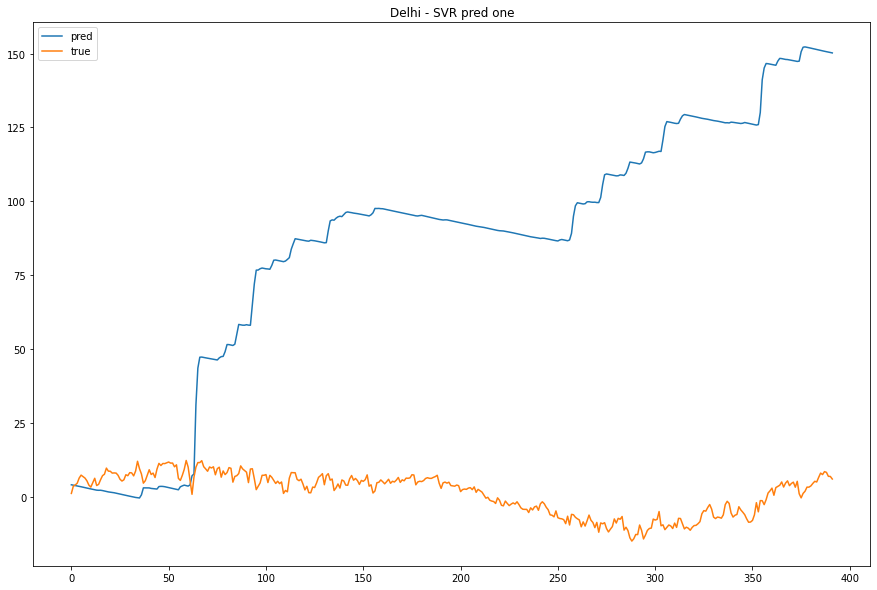

In [87]:
graf_ajuste(pd.Series(forecast_diff.flatten()).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi - SVR pred one')

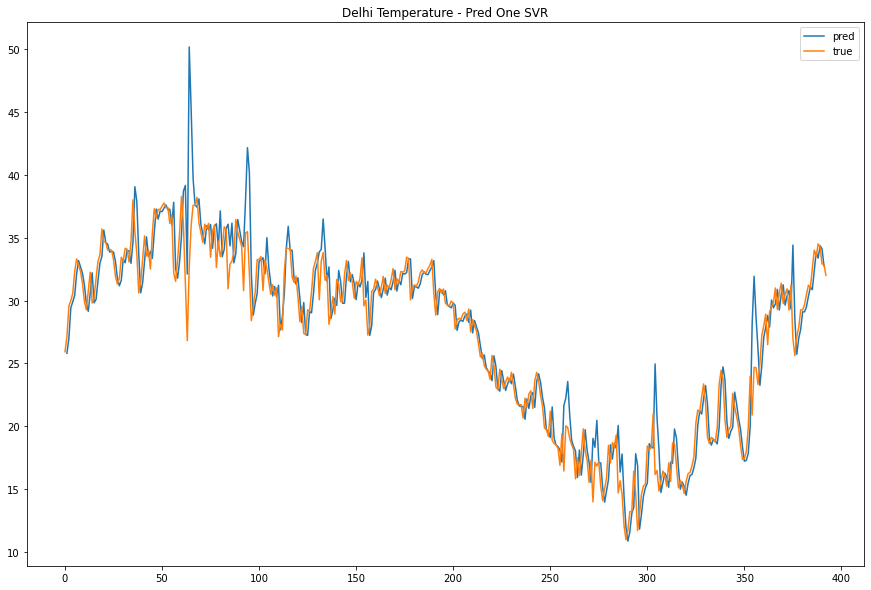

In [88]:
pred_one_svr = y_test.shift(1).reset_index(drop=True).add(pd.Series(forecast_diff.flatten(), name='temperature'),axis=0)
graf_ajuste(pred_one_svr, y_test.reset_index(drop=True), 'Delhi Temperature - Pred One SVR')

In [89]:
show_metrics(y_test.iloc[1:-1], pred_one_svr.iloc[1:-1], results, 'pred one SVR diff')

pred one SVR diff - model Results
r2 0.9005180766294955
mse 4.884266948777514
mae 1.4707788872076883
mape 0.05600440015217438


{'r2': 0.9005180766294955,
 'mse': 4.884266948777514,
 'mae': 1.4707788872076883,
 'mape': 0.05600440015217438}

<AxesSubplot:>

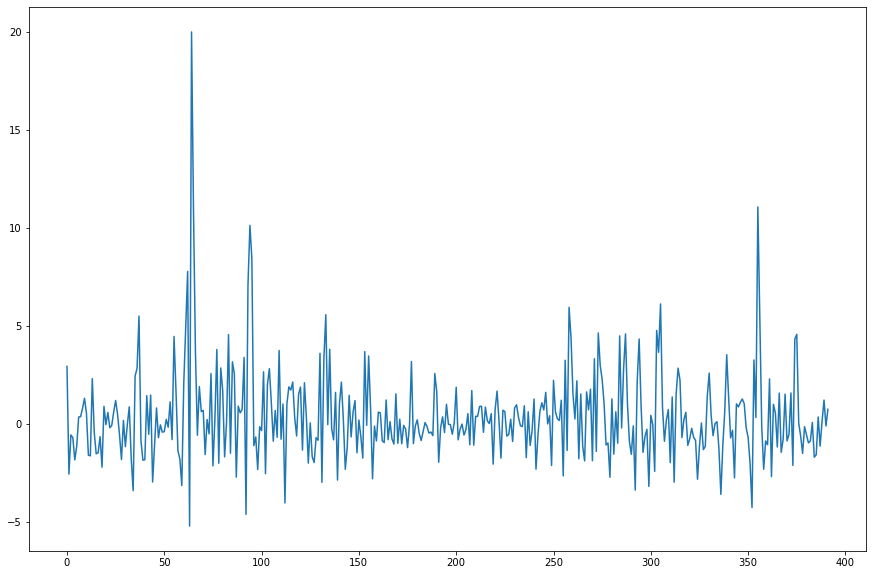

In [90]:
residuos = forecast_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

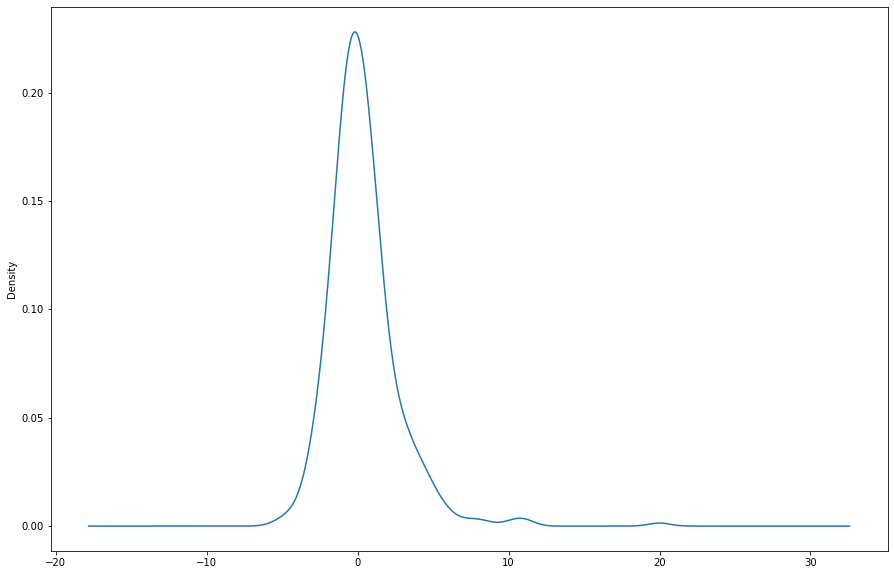

In [91]:
pd.Series(residuos).plot.kde()


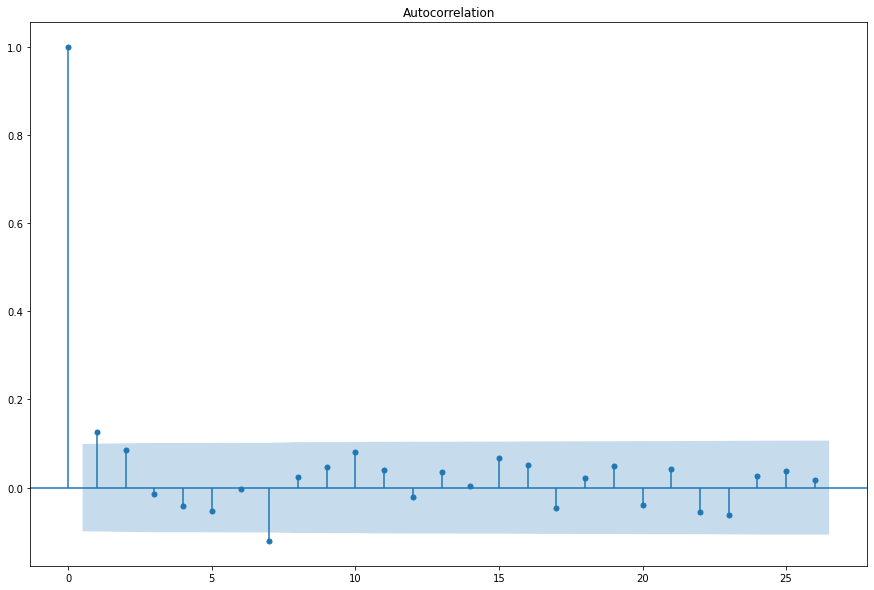

In [92]:
plot_acf(residuos);

In [93]:
pd.DataFrame(results)

ARIMA(5,1,3)  ARIMA(4,1,3)  ARIMA(0,1,3)  ARIMA(2,0,1)    KNN GS  \
r2        0.942899      0.941789      0.942582      0.941540  0.932008   
mse       2.567348      2.617140      2.584069      2.575906  2.881295   
mae       1.228987      1.245434      1.238017      1.238162  1.318350   
mape      0.049238      0.049614      0.049586      0.049453  0.052264   

      d1 KNN GS  pred one KNN GS       SVR    SVR GS     SVR d1  \
r2   -11.389824         0.923579  0.940869  0.940902  -0.852510   
mse    2.803506         3.534372  2.687918  2.691214   5.741806   
mae    1.270539         1.407424  1.242210  1.242234   1.564683   
mape   9.010178         0.056852  0.049588  0.049591  12.454903   

      pred one SVR diff  
r2             0.900518  
mse            4.884267  
mae            1.470779  
mape           0.056004

### MLP

In [95]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

#### Divisão de Dados MLP 

Antes de tudo, foi realizada a divisão dos dados de treino, teste e validação. Diferentemente dos outros algoritmos de ML, a divisão teve que ser explícita, pois a biblioteca utilizada não divide automaticamente os dados.

In [96]:
#Separando os dados - 50% treino, 25% validaçao, 25% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=False, test_size=.333)


#### Diferenciação

Abaixo é realizada a diferenciação da série, pois realizamos o experimento com ela diferenciada e não diferenciada, a fim de entender se há diferenças na performance do modelo.

In [97]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_valid_d1 = X_valid.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_valid_d1 = y_valid.diff().dropna()
y_test_d1 = y_test.diff().dropna()

#### Normalização

A normalização dos valores da série são essenciais para a boa performance do modelo, pois ela possíbilita que a busca pelas regiões que minizam o erro do modelo seja feita de maneira mais eficiente.

In [98]:
X_train_norm = X_train.sub(X_train.mean()).div(X_train.std())
X_valid_norm = X_valid.sub(X_valid.mean()).div(X_valid.std())
X_test_norm = X_test.sub(X_train.mean()).div(X_train.std())

In [99]:
#Valores diferenciados
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_valid_d1_norm = X_valid_d1.sub(X_valid_d1.mean()).div(X_valid_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

<AxesSubplot:xlabel='date'>

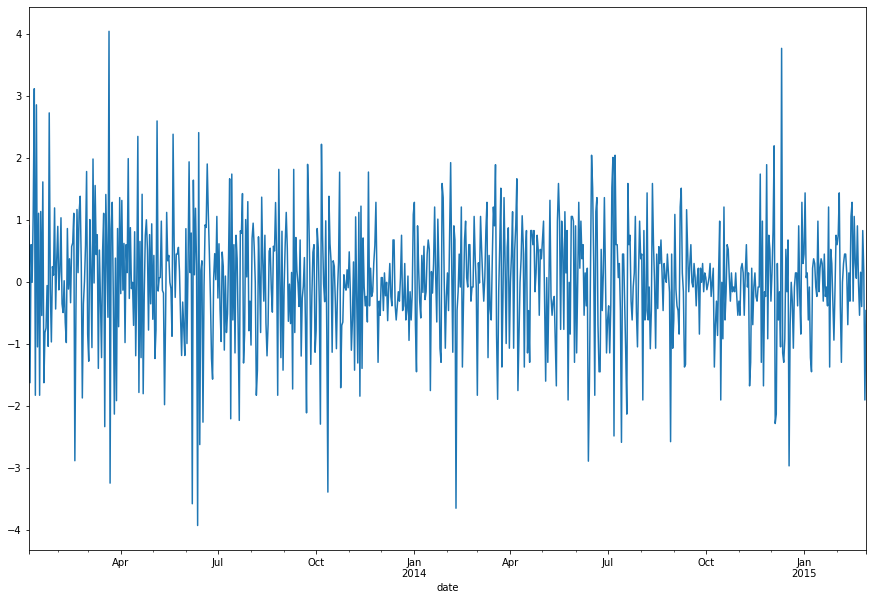

In [100]:
X_train_d1_norm['meantemp-1'].plot()

#### Batches

Abaixo são feita a definição dos batches que alimentam o modelo.

In [101]:
training_data = torch.tensor(pd.concat([X_train_norm, y_train], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_norm, y_valid], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_norm, y_test], axis=1).values)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

In [102]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_d1_norm, y_valid_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)

train_dataloader_d1 = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader_d1 = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader_d1 = DataLoader(testing_data, batch_size=16, shuffle=False)

#### Modelo MLP

A classe MLP abaixo define como será a arquitetura da MLP. Durante o experimento, foram testadas diferentes configuração com a intenção de entender o impacto na performance do modelo.

In [113]:
n_lags = 3

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Config 1
#     self.config1 = nn.Sequential(
#             nn.Linear(n_lags,100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#     )
    
    #Config 2
#     self.config2 = nn.Sequential(
#             nn.Linear(n_lags,32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#     )
     
    # #Config 3
    self.config3 = nn.Sequential(
            nn.Linear(n_lags,32),
            #nn.BatchNorm1d(32), 
            # nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(32, 64),
            #nn.BatchNorm1d(64),
            # nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 1)
    )
  
  def forward(self, X):
    out = self.config3(X)
    return out

#### Funções de treinamento

Abaixo estão as funções que possibilitam que o treinamento do MLP seja realizada diversas vezes, uma vez que serão gerados 10 modelo diferentes.

In [104]:
def train_mlp(model, train_dataloader, valid_dataloader):

  epochs = 200
  loss_fn = nn.MSELoss()
  #optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
  #optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 0.005)
  optimizer = optim.SGD(model.parameters(), lr=0.01)
  
  history_train = {}
  history_valid = {}
  
  for epoch in range(1, epochs+1):
    loss_train = 0.0
    for train_data in train_dataloader:
      x = train_data[:,:n_lags].float()
      y = train_data[:,n_lags].float()
      # print("X: ",x)
      # print("y: ",y)
    
      #forward pass
      outputs = model(x)
      # print("outputs: ", outputs)

      #loss measure
      loss = loss_fn(outputs,y)
      # print("Loss: ", loss)

      #backward pass
      optimizer.zero_grad() # pára o autograd
      loss.backward() # executa o backpropagation
      optimizer.step() # atualiza os pesos

      loss_train += loss.item() # soma os erros para obter o erro total

    loss_valid = 0.0
    for valid_data in valid_dataloader:    
      x = valid_data[:,:n_lags].float()
      y = valid_data[:,n_lags].float()   
      #forward pass
      target = model(x)
      #loss measure
      loss = loss_fn(outputs,y)
      # Calculate Loss
      loss_valid += loss.item()


    if (epoch % 10 == 0):
      print('Epoch{}, train loss {}'.format(epoch, loss_train / len(train_dataloader)))
      print('Epoch{}, valid loss {}'.format(epoch, loss_valid / len(valid_dataloader))) # apresenta o erro médio da época
    history_train[epoch] = loss_train / len(train_dataloader)
    history_valid[epoch] = loss_valid / len(valid_dataloader)

  # pd.Series(history_train).plot()
  # pd.Series(history_valid).plot()
  
  return model


def predict_mlp(model, test_dataloader):
    model.eval()
    results_MLP = []
    for test_data in test_dataloader:
        x = test_data[:,:n_lags].float()
        y = test_data[:,n_lags].float()
        
        y_pred = model(x)
        results_MLP.extend(y_pred.flatten().detach().numpy())
        
    return results_MLP
#pd.DataFrame(results).plot()
# results_MLP[:10]


def get_best_model(metric_name, all_metrics, arr_models):    
    model_metrics = min(all_metrics.keys(), key=(lambda new_k: all_metrics[new_k][metric_name]))
    index_best = model_metrics[-1] 
    return arr_models[int(index_best)]
  
  
def generate_models(train_dataloader, valid_dataloader, y_test, test_dataloader):
    mlp_models = []
    results_metrics_MLP = {}

    for i in range(10):
        print(f"Modelo {i}")
        multi_neuron = MLP()
        
        train_mlp(multi_neuron, train_dataloader, valid_dataloader)
        mlp_models.append(multi_neuron)
        results_MLP = predict_mlp(multi_neuron, valid_dataloader)
        #results_MLP = predict_mlp(multi_neuron, test_dataloader)
        
        show_metrics(y_test,results_MLP, results_metrics_MLP, f'MLP{i}')
        
    return mlp_models, results_metrics_MLP

#### Treinando MLP

Esta função é responsável pelo pipeline da experimento da MLP, nela serão executadas 10 vezes o treinamento e teste dos modelos.

In [105]:
mlp_models, results_metrics_MLP = generate_models(train_dataloader, valid_dataloader, y_test, test_dataloader)

Modelo 0
Epoch10, train loss 17.441948652267456
Epoch10, valid loss 98.01613077163697
Epoch20, train loss 17.95534121990204
Epoch20, valid loss 95.88901781082153
Epoch30, train loss 18.722934489250182
Epoch30, valid loss 90.67548095703125
Epoch40, train loss 19.421313920021056
Epoch40, valid loss 86.78501934051513
Epoch50, train loss 20.785310139656065
Epoch50, valid loss 85.78615777015686
Epoch60, train loss 21.51062042236328
Epoch60, valid loss 80.11595737457276
Epoch70, train loss 22.43674295902252
Epoch70, valid loss 75.67105625152588
Epoch80, train loss 23.260144333839417
Epoch80, valid loss 73.43977703094482
Epoch90, train loss 24.050393357276917
Epoch90, valid loss 69.19778408050537
Epoch100, train loss 24.754325652122496
Epoch100, valid loss 67.10465269088745
Epoch110, train loss 25.424382543563844
Epoch110, valid loss 64.24183671951295
Epoch120, train loss 26.005041470527647
Epoch120, valid loss 66.52755847930908
Epoch130, train loss 26.23632887363434
Epoch130, valid loss 61.6

In [106]:
pd.DataFrame(results_metrics_MLP)

MLP0        MLP1        MLP2        MLP3        MLP4       MLP5  \
r2     -1.360529   -0.545578   -0.260540   -0.319549   -0.614424  -0.512366   
mse   165.892945  140.623256  294.331170  190.042446  173.993492  72.365351   
mae     9.926189    9.082287   13.526999   10.680303   10.385157   6.623051   
mape    0.378265    0.366140    0.463909    0.355918    0.332833   0.295811   

            MLP6        MLP7        MLP8        MLP9  
r2     -1.916069   -1.257025   -0.746952   -3.056626  
mse   100.297941  260.857292  397.616962  308.828952  
mae     8.529698   13.595006   12.702175   15.731178  
mape    0.395739    0.715820    0.361196    3.239739

Abaixo é escolhido melhor modelo e apresentado seus resultados.

In [107]:
best_MLP = get_best_model("mse", results_metrics_MLP, mlp_models)
pred_best_MLP = predict_mlp(best_MLP, test_dataloader)

In [108]:
show_metrics(y_test,pred_best_MLP, results, 'MLP')

MLP - model Results
r2 0.6192558606707
mse 22.63492357188227
mae 3.780447739164113
mape 0.15690430020281698


{'r2': 0.6192558606707,
 'mse': 22.63492357188227,
 'mae': 3.780447739164113,
 'mape': 0.15690430020281698}

<AxesSubplot:>

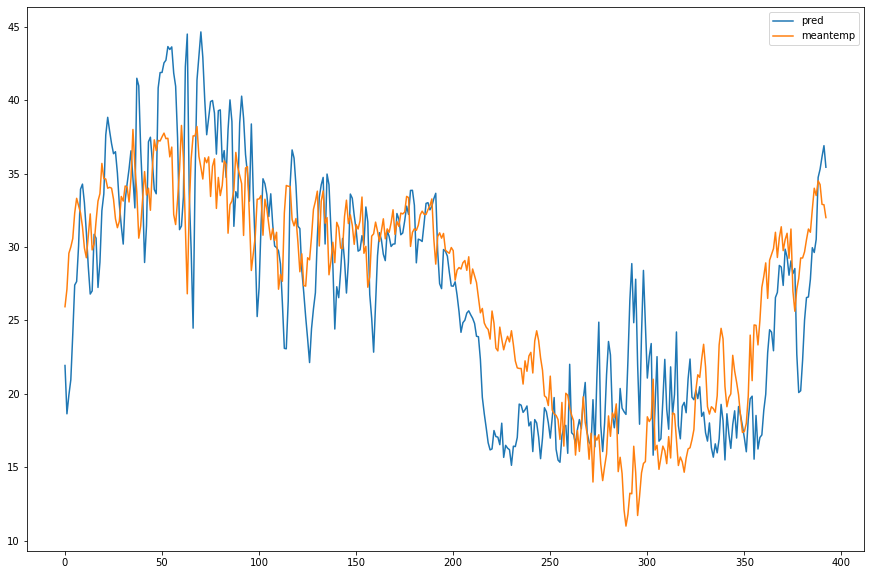

In [109]:
pd.concat([pd.Series(pred_best_MLP, name='pred'), y_test.reset_index(drop=True)],axis=1).plot()

Analise do resíduo

<AxesSubplot:>

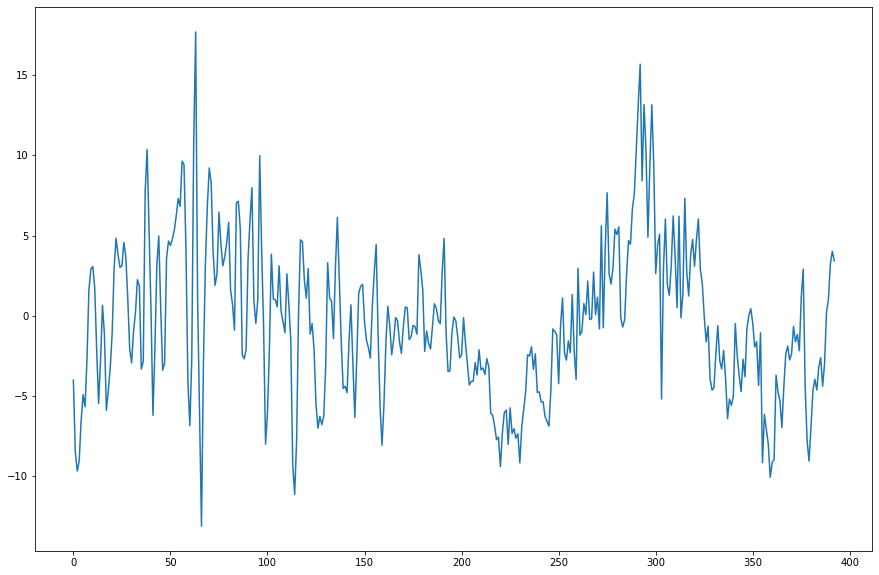

In [110]:
residuos = pred_best_MLP - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

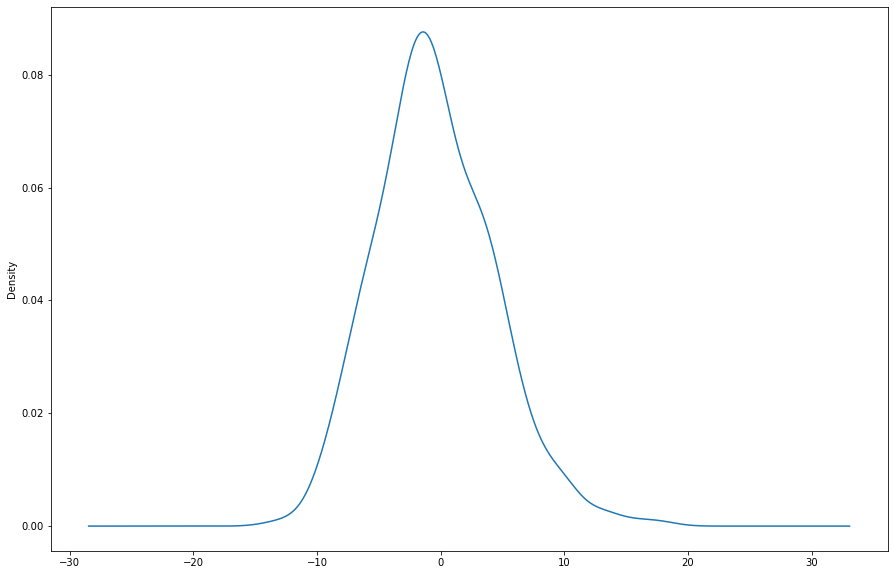

In [111]:
pd.Series(residuos).plot.kde()

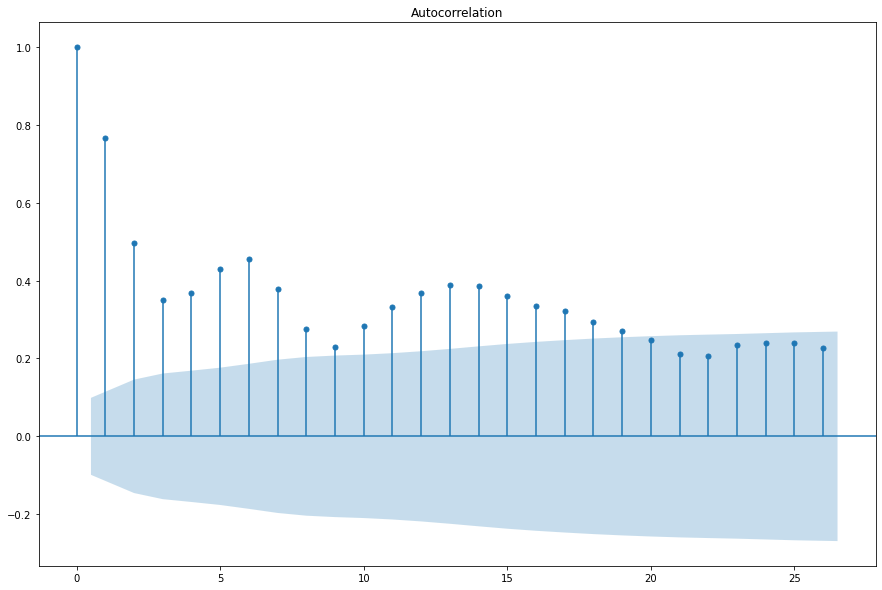

In [112]:
plot_acf(residuos);

#### Com dados diferenciados

O mesmo procedimento seguido acima foi realizado com os dados diferenciados.

In [114]:
mlp_models_d1, results_metrics_MLP_d1 = generate_models(train_dataloader_d1, valid_dataloader_d1, y_test_d1, test_dataloader_d1)

Modelo 0
Epoch10, train loss 2.7232345277071
Epoch10, valid loss 3.0106114518642424
Epoch20, train loss 2.7153232964873313
Epoch20, valid loss 3.0797324800491332
Epoch30, train loss 2.709486492276192
Epoch30, valid loss 3.1574002289772034
Epoch40, train loss 2.7050713899731638
Epoch40, valid loss 3.2371090340614317
Epoch50, train loss 2.7011518886685373
Epoch50, valid loss 3.314824345111847
Epoch60, train loss 2.697337770164013
Epoch60, valid loss 3.398953685760498
Epoch70, train loss 2.694105339348316
Epoch70, valid loss 3.473432378768921
Epoch80, train loss 2.6912574502825737
Epoch80, valid loss 3.5876014399528504
Epoch90, train loss 2.6881265795230864
Epoch90, valid loss 3.661547522544861
Epoch100, train loss 2.685671636760235
Epoch100, valid loss 3.7555583572387694
Epoch110, train loss 2.683520780801773
Epoch110, valid loss 3.860770597457886
Epoch120, train loss 2.681423473060131
Epoch120, valid loss 3.9395438623428345
Epoch130, train loss 2.679299711883068
Epoch130, valid loss 4.0

In [115]:
pd.DataFrame(results_metrics_MLP_d1)

MLP0        MLP1        MLP2        MLP3        MLP4        MLP5  \
r2   -198.317458 -160.861396 -174.990493 -183.915191 -173.486010 -176.501574   
mse     2.780958    2.765345    2.768600    2.766761    2.754839    2.782915   
mae     1.267047    1.264033    1.262944    1.263655    1.262285    1.266890   
mape  105.073692   64.765257   46.527204   58.687856  328.020112   86.428944   

            MLP6        MLP7        MLP8        MLP9  
r2   -190.346830 -150.251417 -163.801652 -217.428168  
mse     2.771118    2.768598    2.767848    2.769545  
mae     1.265855    1.265481    1.264148    1.265258  
mape   82.255272   53.944901  187.581412   70.034804

Resultados do melhor modelo

In [116]:
best_MLP_d1 = get_best_model("mse", results_metrics_MLP_d1, mlp_models_d1)
pred_best_MLP_d1 = predict_mlp(best_MLP_d1, test_dataloader_d1)

In [117]:
show_metrics(y_test_d1,pred_best_MLP_d1, results, 'MLP-d1')

MLP-d1 - model Results
r2 -181.9492296375776
mse 2.77522343770099
mae 1.2624933424868412
mape 83.76897317908279


{'r2': -181.9492296375776,
 'mse': 2.77522343770099,
 'mae': 1.2624933424868412,
 'mape': 83.76897317908279}

<AxesSubplot:>

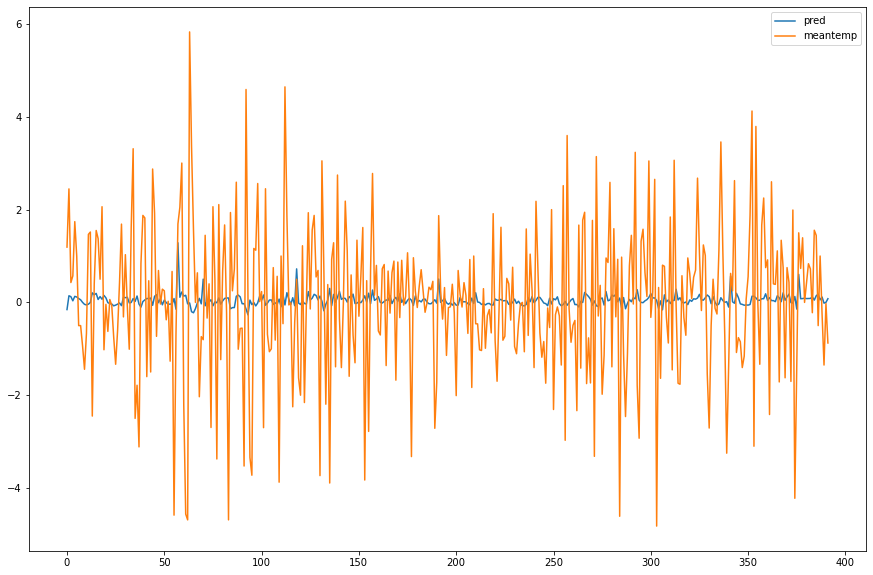

In [118]:
pd.concat([pd.Series(pred_best_MLP_d1, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

Analise do resíduo

<AxesSubplot:>

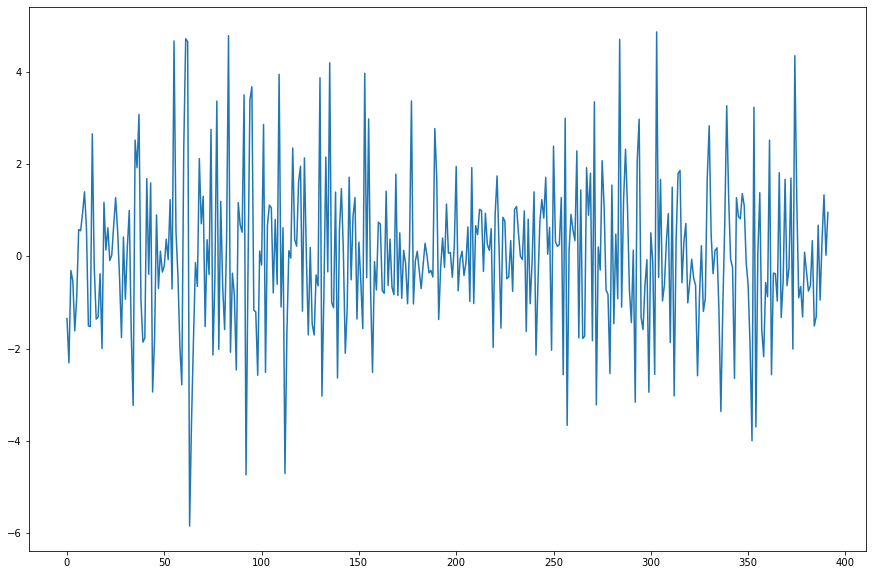

In [119]:
residuos = pred_best_MLP_d1 - y_test_d1.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

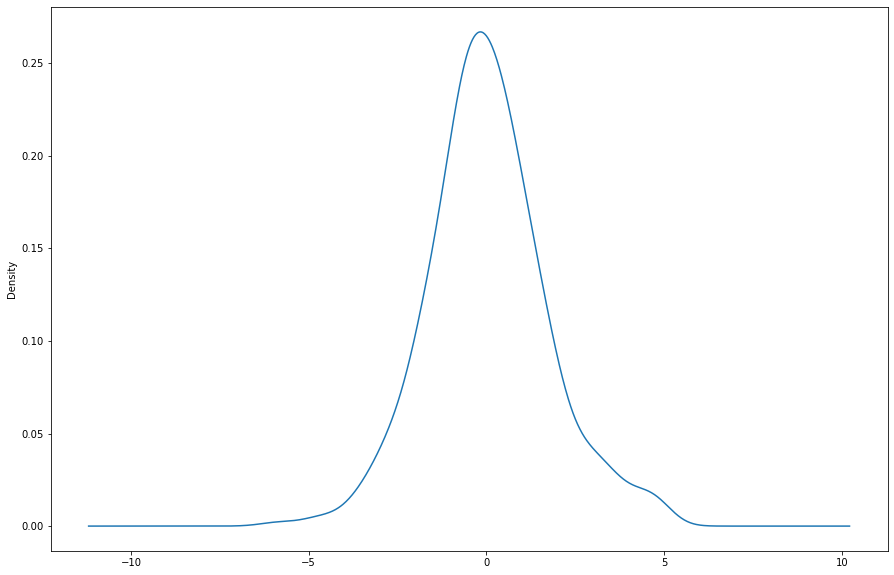

In [120]:
pd.Series(residuos).plot.kde()

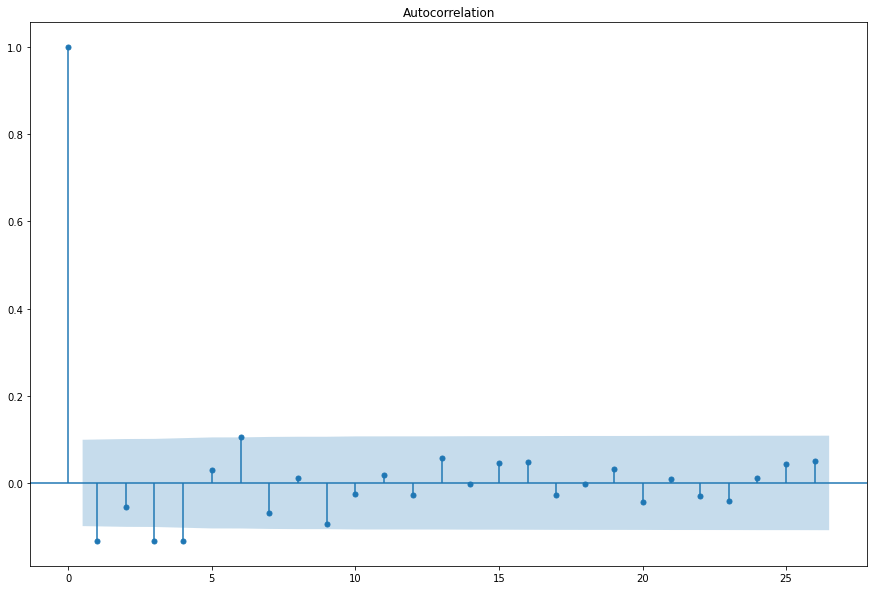

In [121]:
plot_acf(residuos);

Ao final, verificamos que a série diferenciada obteve melhores resultados que a série sem diferenciação. No entanto, a performance do modelo de MLP ainda está banstante aquém quando comparado com os outros modelos. Talvez seja necessário utilizar outra arquitetura de rede neurárais a fim de obter melhores resultados.

## Resultado dos Modelos

In [122]:
pd.DataFrame(results)

ARIMA(5,1,3)  ARIMA(4,1,3)  ARIMA(0,1,3)  ARIMA(2,0,1)    KNN GS  \
r2        0.942899      0.941789      0.942582      0.941540  0.932008   
mse       2.567348      2.617140      2.584069      2.575906  2.881295   
mae       1.228987      1.245434      1.238017      1.238162  1.318350   
mape      0.049238      0.049614      0.049586      0.049453  0.052264   

      d1 KNN GS  pred one KNN GS       SVR    SVR GS     SVR d1  \
r2   -11.389824         0.923579  0.940869  0.940902  -0.852510   
mse    2.803506         3.534372  2.687918  2.691214   5.741806   
mae    1.270539         1.407424  1.242210  1.242234   1.564683   
mape   9.010178         0.056852  0.049588  0.049591  12.454903   

      pred one SVR diff        MLP      MLP-d1  
r2             0.900518   0.619256 -181.949230  
mse            4.884267  22.634924    2.775223  
mae            1.470779   3.780448    1.262493  
mape           0.056004   0.156904   83.768973

In [ ]:
# graf_ajuste(pd.Series(pred_best_MLP).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi Temperatue - MLP')

In [ ]:
# pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(pred_best_MLP, name='temperature'),axis=0)
# graf_ajuste(pred_one, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [ ]:
# pred_one = pred_one.fillna(method='bfill')
# show_metrics(y_test[:-1],pred_one[:-1] , results, 'MLP pred_one')